# Data Sampling, Model Comparison, and XAI (SMOTE vs ADASYN)

This notebook is part of the **Credit Risk Classification with Imbalanced Data** project.  
It focuses on how different resampling techniques affect both **predictive performance** and **model interpretability**.

## Objectives

- Analyse the **class imbalance** in the 3-level risk dataset (`Risk_Level` = Low, Moderate, High).
- Apply **oversampling methods** to balance the training data:
  - SMOTE (Synthetic Minority Over-sampling Technique)
  - ADASYN (Adaptive Synthetic Sampling)
- Train and compare three classifiers:
  - **XGBoost**
  - **AdaBoost** (with a DecisionTree base estimator)
  - **ANN** (MLPClassifier)
- Evaluate performance using:
  - Overall Accuracy and F1-score
  - ROC–AUC (per class and macro)
  - Precision–Recall curves and **Average Precision (AP)** for each class
- Use **SHAP** to study how sampling changes:
  - Feature importance ranking
  - Feature interactions (e.g. `TMDB_NUV`, `TMDB_Popularity`, `TMDB_Mean_UVR`)
- Perform a **SHAP stability analysis (SRA)** under different imbalance levels.

## Workflow in this notebook

1. **Load and preprocess the dataset**
   - Read `FinalData_3_RiskLevels.xlsx` from Google Drive.
   - Separate features and target (`Risk_Level`).
   - Encode the target with `LabelEncoder` and one-hot encode input features.
   - Split into train / test sets.

2. **Inspect class imbalance**
   - Compute class counts for the three risk levels.
   - Highlight the imbalance problem that motivates the use of resampling.

3. **Define and tune sampling techniques**
   - Configure **SMOTE** (e.g. `k_neighbors`, `sampling_strategy`).
   - Configure **ADASYN** (e.g. `n_neighbors`, `sampling_strategy`).
   - Optionally define a **RandomUnderSampler** for comparison.
   - Select **best-performing configurations** for each sampling method.

4. **Train models under each sampling method**
   For each of SMOTE and ADASYN:
   - Resample the **training set** only.
   - Fit:
     - XGBoost classifier
     - AdaBoost classifier (DecisionTree base estimator)
     - ANN (MLPClassifier)
   - Evaluate on the **same untouched test set**.

5. **Evaluate performance**
   - Compute Accuracy, F1-score, and ROC–AUC.
   - Generate ROC curves and Precision–Recall curves.
   - Report **Average Precision (AP)** per class to reflect performance on the imbalanced labels.

6. **SHAP-based analysis (XGBoost)**
   - Use `shap.TreeExplainer` to compute SHAP values for:
     - **XGBoost + SMOTE**
     - **XGBoost + ADASYN**
   - Plot:
     - SHAP **summary plots** to compare global feature importance.
     - SHAP **interaction plots** (e.g. `TMDB_Popularity` × `TMDB_NUV`) to visualize how feature interactions differ between SMOTE and ADASYN.
   - Interpret how each sampling method changes:
     - Which features are most important.
     - How strongly they push the prediction towards each risk level.

7. **SHAP Stability Rate Analysis (SRA)**
   - Simulate different **imbalance levels** by resampling the data with varying default rates.
   - For each scenario:
     - Refit XGBoost.
     - Recompute SHAP values.
     - Calculate **SRA** scores to measure how stable the **top-ranked features** are across imbalance levels.
   - Compare SRA curves for:
     - XGBoost with SMOTE
     - XGBoost with ADASYN

8. **Key takeaways**
   - Both SMOTE and ADASYN can improve performance on the minority classes.
   - For **XGBoost**, ADASYN may yield slightly better AP in some cases, but SHAP patterns can be more variable.
   - For **ANN**, SMOTE tends to be more reliable, especially for the middle-risk class.
   - From an XAI perspective, SMOTE often produces **more stable feature rankings and interactions**, which can be preferable for risk modelling.


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/RiskPaper/FinalData_3_RiskLevels.xlsx"
df = pd.read_excel(file_path)
print(df.head())

   TMDB_NUV  TMDB_Mean_UVR  TMDB_Popularity  \
0     34315          8.434          443.779   
1     29865          7.612          538.680   
2     28865          8.246          362.473   
3     27416          7.908           67.192   
4     24858          8.255          299.860   

                                Genre  \
0   Adventure, Drama, Science Fiction   
1           Action, Adventure, Comedy   
2  Adventure, Action, Science Fiction   
3  Action, Science Fiction, Adventure   
4  Adventure, Science Fiction, Action   

                                            Keywords   R1   R2   R3   R4   R5  \
0  rescue, future, spacecraft, race against time,...  340  121  137  153  183   
1  superhero, anti hero, mercenary, based on comi...  112   41   44   36   50   
2  sacrifice, magic, superhero, based on comic, s...  235   88   96  102  164   
3  spacecraft, based on comic, space, orphan, adv...   82   21   34   34   53   
4  superhero, time travel, space travel, time mac...  597  189  2

In [ ]:
class_counts = df["Risk_Level"].value_counts()
print(class_counts)

Risk_Level
2    861
0    432
1    265
Name: count, dtype: int64


In [ ]:
# XGBoost
# Separate features and target
X = df.drop("Risk_Level", axis=1)  # Features
y = df["Risk_Level"]  # Target (dependent variable)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets using the encoded features
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.63%


In [ ]:
# Step 2: Initial Sampling for Local Interpretation
# Randomly select a subset of the dataset (Targetset) for local interpretation using SHAP and LIME.
# Select a random subset of the training set for local interpretation
T = 50  # Size of the Targetset
np.random.seed(42)
target_indices = np.random.choice(len(X_train), T, replace=False)

Targetset_X = X_train.iloc[target_indices]
Targetset_y = y_train[target_indices]

In [ ]:
# Step 3: Data Sampling (Resampling Techniques)
# This step involves applying resampling techniques (such as SMOTE, undersampling, or a combination) to balance the dataset.
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Step 4: Classifier Training and Prediction
# Train an XGBoost model on the resampled training data and make predictions for the target set.
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions for the target set
y_pred_target = xgb_model.predict(Targetset_X)

In [ ]:
import shap

# SHAP explanation for XGBoost multi-class model
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for all features (this is a list of arrays, one for each class)
shap_values = explainer.shap_values(Targetset_X)

# For class 0, extract the SHAP values
class_idx = 0  # Class index for class 0
base_value_class_0 = explainer.expected_value[class_idx]  # Base value for class 0

# Extract the SHAP values for class 0 (each feature will have only 1 value for class 0)
shap_force_values_class_0 = shap_values[class_idx][:, 0]  # SHAP values for class 0

# Now check the shape
print(f"Shape of SHAP values for class 0 (after extraction): {shap_force_values_class_0.shape}")
print(f"Shape of feature vector: {Targetset_X.iloc[0].shape}")

# Visualize SHAP force plot for the first instance in class 0
shap.initjs()

# Make sure to pass SHAP values for the first instance, matching the number of features
shap.force_plot(base_value_class_0, shap_force_values_class_0, Targetset_X.iloc[0])

Shape of SHAP values for class 0 (after extraction): (2142,)
Shape of feature vector: (2142,)


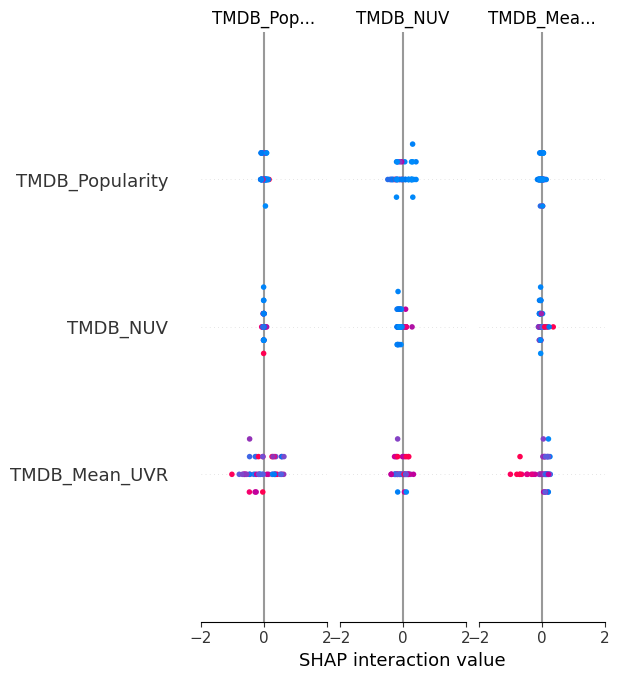

In [ ]:
import matplotlib.pyplot as plt
# SHAP values for the resampled model
explainer_resampled = shap.TreeExplainer(xgb_model)
shap_values_resampled = explainer_resampled.shap_values(Targetset_X)

# Generate the SHAP summary plot without showing it immediately
shap.summary_plot(shap_values_resampled, Targetset_X, show=False)

# Get the current figure and all the axes in the plot
fig = plt.gcf()
axes = fig.get_axes()

# Adjust the X-axis limits for all axes (columns) in the plot
for ax in axes:
    ax.set_xlim(-2, 2)  # Set X-axis limits to -2 to 2

# Show the modified plot
plt.show()

In [ ]:
# Convert stability_results to a NumPy array for easier manipulation
stability_results_np = np.array(stability_results)  # Shape: (B, n_samples, n_features)

# Calculate the mean and standard deviation of SHAP values across iterations
mean_shap_values = np.mean(np.abs(stability_results_np), axis=0)  # Shape: (n_samples, n_features)
std_shap_values = np.std(np.abs(stability_results_np), axis=0)    # Shape: (n_samples, n_features)

# Optionally, you could calculate the mean and std for each feature across all samples:
mean_shap_values_per_feature = np.mean(mean_shap_values, axis=0)  # Shape: (n_features,)
std_shap_values_per_feature = np.mean(std_shap_values, axis=0)    # Shape: (n_features,)

In [ ]:
print(mean_shap_values_per_feature.shape)
print(std_shap_values_per_feature.shape)

(2142, 3)
(2142, 3)


In [ ]:
# Print the shape of mean and standard deviation arrays
print(f"Shape of mean SHAP values: {mean_shap_values_per_feature.shape}")
print(f"Shape of std SHAP values: {std_shap_values_per_feature.shape}")

Shape of mean SHAP values: (2142, 3)
Shape of std SHAP values: (2142, 3)


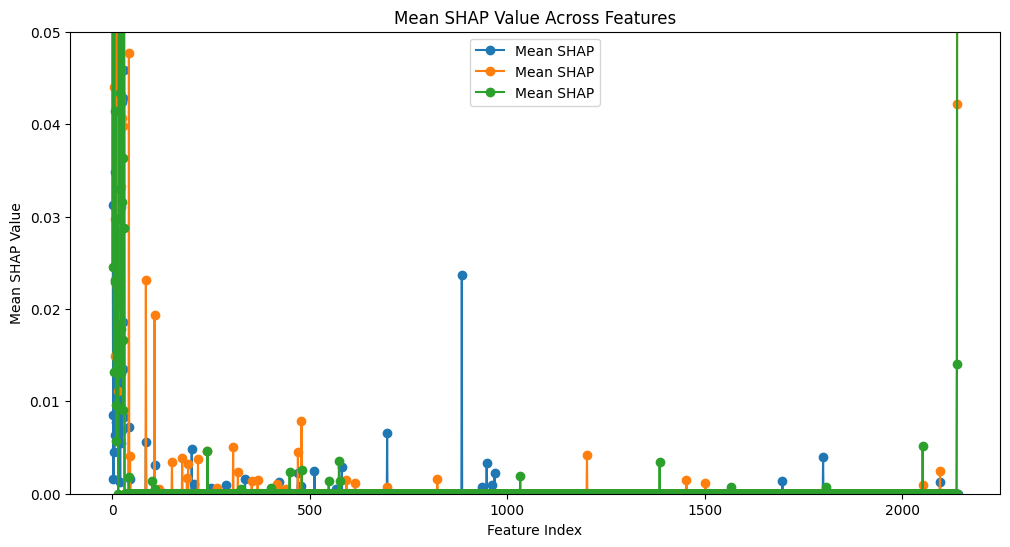

In [ ]:
# Create a simple line plot without error bars
plt.figure(figsize=(12, 6))
plt.plot(range(len(mean_shap_values_per_feature)), mean_shap_values_per_feature, 'o-', label='Mean SHAP')
plt.ylim(0, 0.05)
plt.title('Mean SHAP Value Across Features')
plt.xlabel('Feature Index')
plt.ylabel('Mean SHAP Value')
plt.legend()
plt.show()

In [ ]:
# There are a few features with extremely high SHAP values (specifically around index 0). These features have a much larger impact on the model's predictions compared to the rest.
# Most of the features have very low or near-zero SHAP values, indicating that they contribute little or nothing to the model's predictions.
# This is common in many models, where only a handful of features drive the majority of the predictive power, while many other features contribute very little.
# The sharp spike in the first few feature indices suggests that these features are the most important for the model, as they have the highest average SHAP values.
# The SHAP values for the rest of the features are essentially zero, meaning these features have little impact on the model.

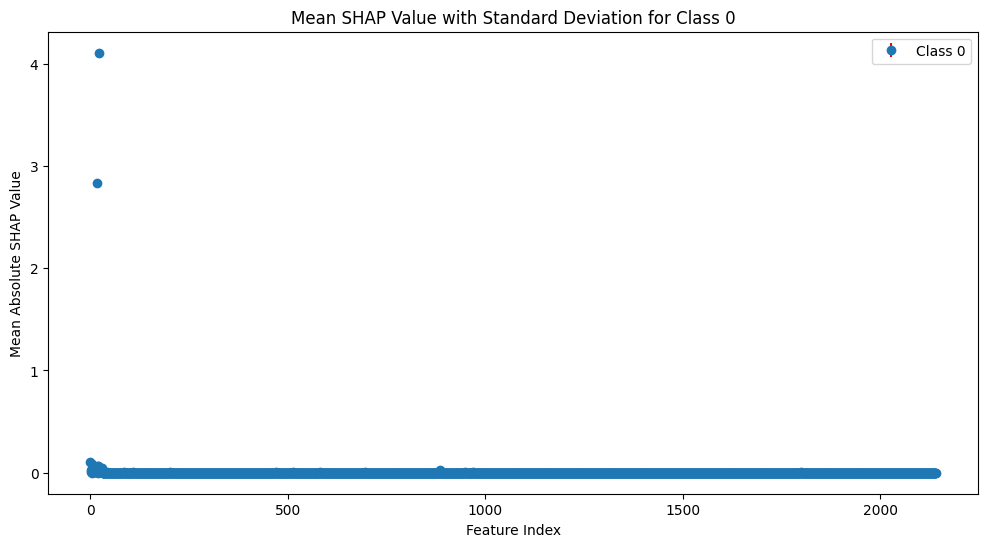

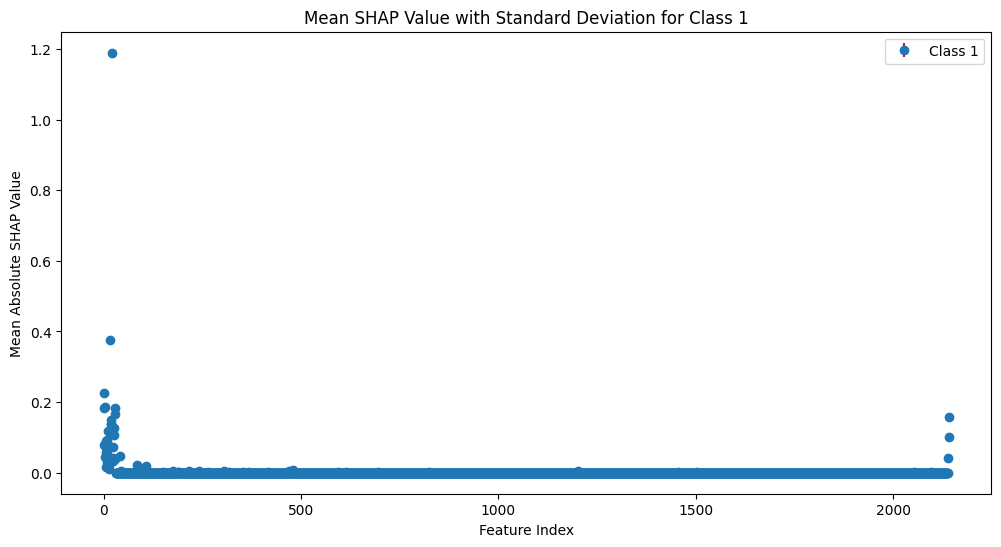

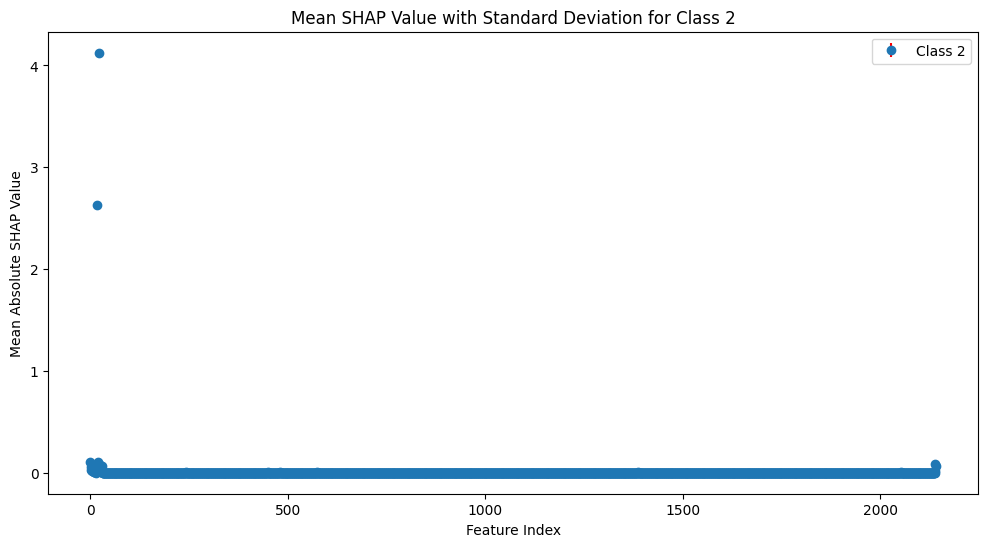

In [ ]:
# Loop through each class and plot separately
for i in range(3):  # Assuming there are 3 classes
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        range(len(mean_shap_values_per_feature[:, i])),  # X-axis: Feature indices
        mean_shap_values_per_feature[:, i],              # Y-axis: Mean SHAP values for class i
        yerr=std_shap_values_per_feature[:, i],          # Error bars: Std deviation for class i
        fmt='o', ecolor='r', capthick=2, label=f'Class {i}'
    )
    plt.title(f'Mean SHAP Value with Standard Deviation for Class {i}')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Absolute SHAP Value')
    plt.legend()
    plt.show()

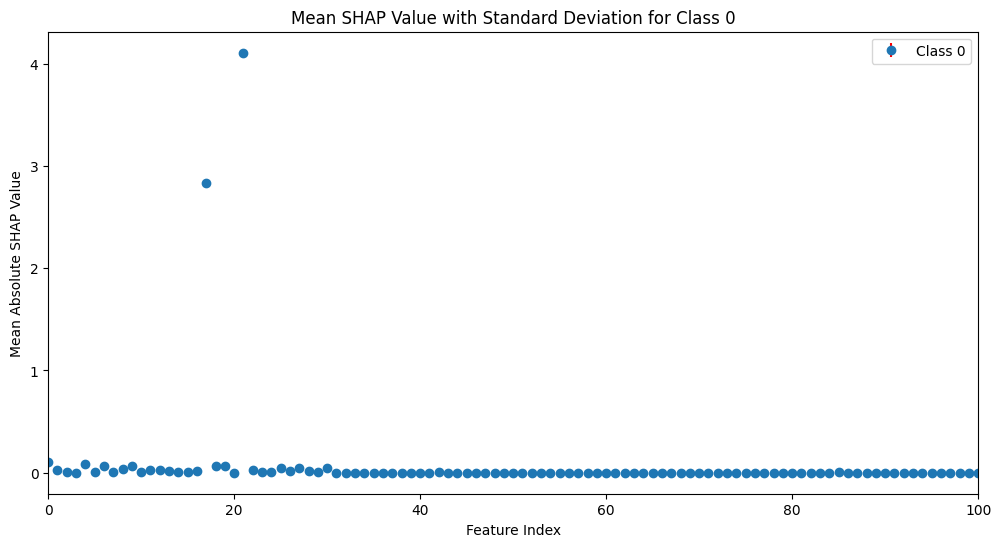

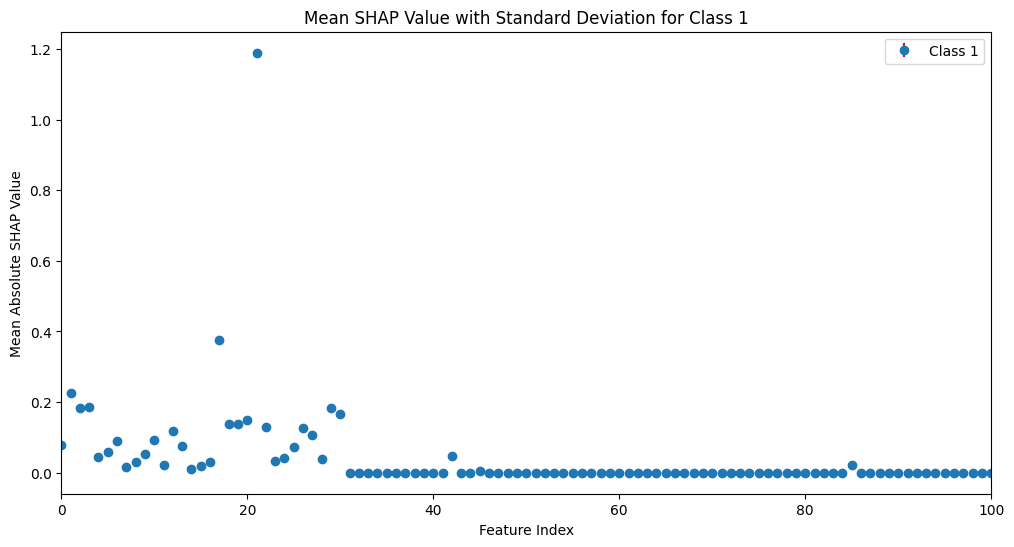

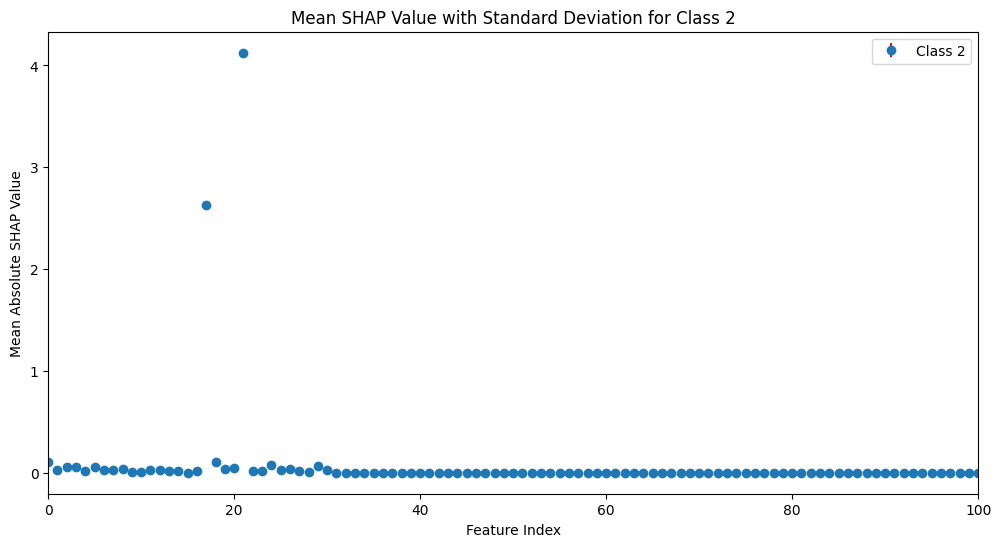

In [ ]:
for i in range(3):  # Assuming there are 3 classes
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        range(len(mean_shap_values_per_feature[:, i])),  # X-axis: Feature indices
        mean_shap_values_per_feature[:, i],              # Y-axis: Mean SHAP values for class i
        yerr=std_shap_values_per_feature[:, i],          # Error bars: Std deviation for class i
        fmt='o', ecolor='r', capthick=2, label=f'Class {i}'
    )

    # Adjust the X-axis limits to zoom in on a subset of features
    plt.xlim(0, 100)  # Modify these values to zoom in on specific feature indices

    plt.title(f'Mean SHAP Value with Standard Deviation for Class {i}')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Absolute SHAP Value')
    plt.legend()
    plt.show()

In [ ]:
# Define Sampling Techniques and Their Hyperparameters: Define multiple sampling techniques and set up their hyperparameter grids. Here’s an example with SMOTE, ADASYN, and RandomUnderSampler.
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ParameterGrid

# Define custom sampling strategies for multiclass cases
smote_param_grid = {
    'k_neighbors': [3, 5, 7],
    'sampling_strategy': [
        {0: 400, 1: 300, 2: 750},  # Slightly above the original counts
        {0: 500, 1: 400, 2: 800}   # Increased counts for more oversampling
    ]
}

adasyn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'sampling_strategy': [
        {0: 400, 1: 300, 2: 750},
        {0: 500, 1: 400, 2: 800}
    ]
}

random_undersampler_param_grid = {
    'sampling_strategy': [
        {0: 200, 1: 150, 2: 300},  # Undersample to reduce the dataset size
        {0: 250, 1: 200, 2: 350}
    ]
}

# Define a hyperparameter grid for each sampling technique
sampling_methods = {
    'SMOTE': {
        'sampler': SMOTE,
        'params': smote_param_grid
    },
    'ADASYN': {
        'sampler': ADASYN,
        'params': adasyn_param_grid
    },
    'RandomUnderSampler': {
        'sampler': RandomUnderSampler,
        'params': random_undersampler_param_grid
    }
}

# Generate hyperparameter combinations for each method
sampling_hyperparameters = {}
for method_name, method_info in sampling_methods.items():
    sampler_class = method_info['sampler']
    param_grid = list(ParameterGrid(method_info['params']))
    sampling_hyperparameters[method_name] = [
        {'sampler': sampler_class(**params), 'params': params} for params in param_grid
    ]

In [ ]:
# Initialize Containers to Store Results: Use dictionaries to store stability and performance metrics for each combination of sampling technique and hyperparameters.
stability_results_per_method = {}
performance_results_per_method = {}

In [ ]:
# Iterate Over Sampling Methods and Hyperparameter Combinations: For each sampling technique and hyperparameter combination, perform stability analysis and evaluate model performance.
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm

B = 10  # Number of iterations for stability analysis

# Loop through each sampling technique with a progress bar
for method_name, configs in tqdm(sampling_hyperparameters.items(), desc="Sampling Methods"):
    stability_results = []
    performance_metrics = []

    # Loop through each hyperparameter combination for the method
    for config in tqdm(configs, desc=f"Config {method_name}", leave=False):
        sampler = config['sampler']
        stability_results_config = []
        performance_metrics_config = []

        # Stability analysis for SHAP values
        for b in tqdm(range(B), desc="Iterations", leave=False):
            # Resample using the current sampling method and hyperparameters
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

            # Train the model
            xgb_model.fit(X_train_resampled, y_train_resampled)

            # Get SHAP values for the target set
            explainer = shap.TreeExplainer(xgb_model)
            shap_values_b = explainer.shap_values(Targetset_X)

            # Append SHAP values for stability analysis
            stability_results_config.append(shap_values_b)

            # Calculate model performance (e.g., accuracy, F1-score, AUC) on the test set
            y_pred = xgb_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test), multi_class='ovr')

            # Store performance metrics for this iteration
            performance_metrics_config.append({
                'accuracy': accuracy,
                'f1_score': f1,
                'auc': auc
            })

        # Analyze SHAP Stability for the Current Sampling Parameters
        stability_results_np = np.array(stability_results_config)
        mean_shap_values = np.mean(np.abs(stability_results_np), axis=0)
        std_shap_values = np.std(np.abs(stability_results_np), axis=0)

        # Coefficient of Variation (CV) with epsilon to avoid division by zero
        epsilon = 1e-10
        cv_shap_values = std_shap_values / (mean_shap_values + epsilon)  # Or use np.where if preferred

        # Store the average CV across features as a stability metric
        mean_cv = np.mean(cv_shap_values)

        # Calculate average performance metrics
        avg_accuracy = np.mean([m['accuracy'] for m in performance_metrics_config])
        avg_f1_score = np.mean([m['f1_score'] for m in performance_metrics_config])
        avg_auc = np.mean([m['auc'] for m in performance_metrics_config])

        # Store results for this hyperparameter configuration
        stability_results.append({'params': config['params'], 'mean_cv': mean_cv})
        performance_metrics.append({
            'params': config['params'],
            'accuracy': avg_accuracy,
            'f1_score': avg_f1_score,
            'auc': avg_auc
        })

    # Save results per method
    stability_results_per_method[method_name] = stability_results
    performance_results_per_method[method_name] = performance_metrics

Config SMOTE:   0%|          | 0/6 [00:00<?, ?it/s]

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iterations:  10%|█         | 1/10 [00:06<00:58,  6.46s/it]

Iterations:  20%|██        | 2/10 [00:11<00:45,  5.68s/it]

Iterations:  30%|███       | 3/10 [00:19<00:47,  6.77s/it]

Iterations:  40%|████      | 4/10 [00:24<00:37,  6.20s/it]

Iterations:  50%|█████     | 5/10 [00:33<00:34,  6.86s/it]

Iterations:  60%|██████    | 6/10 [00:38<00:25,  6.28s/it]

Iterations:  70%|███████   | 7/10 [00:46<00:20,  6.80s/it]

Iterations:  80%|████████  | 8/10 [00:51<00:12,  6.35s/it]

Iterations:  90%|█████████ | 9/10 [00:59<00:06,  6.85s/it]

Iterations: 100%|██████████| 10/10 [01:04<00:00,  6.35s/it]

                                                           
Config SMOTE:  17%|█▋        | 1/6 [01:04<05:23, 64.64s/it]

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iterations:  10%|█         | 1/10 [00:06<01:01,  6.86s/it]

Iterations:  20%|██        | 2/10 [00:12<00:47,  5.92s/it]

I

In [ ]:
# Print or summarize the best results for each method
for method_name in sampling_methods.keys():
    # Find the best stability configuration
    best_stability = min(stability_results_per_method[method_name], key=lambda x: x['mean_cv'])
    print(f"Best Stability Configuration for {method_name}: {best_stability}")

    # Find the best performance configuration
    best_performance = max(performance_results_per_method[method_name], key=lambda x: x['auc'])
    print(f"Best Performance Configuration for {method_name}: {best_performance}")

Best Stability Configuration for SMOTE: {'params': {'k_neighbors': 3, 'sampling_strategy': {0: 400, 1: 300, 2: 750}}, 'mean_cv': 0.04620748}
Best Performance Configuration for SMOTE: {'params': {'k_neighbors': 3, 'sampling_strategy': {0: 500, 1: 400, 2: 800}}, 'accuracy': 0.9375, 'f1_score': 0.912969625793054, 'auc': 0.9890098089752263}
Best Stability Configuration for ADASYN: {'params': {'n_neighbors': 7, 'sampling_strategy': {0: 400, 1: 300, 2: 750}}, 'mean_cv': 0.046876952}
Best Performance Configuration for ADASYN: {'params': {'n_neighbors': 5, 'sampling_strategy': {0: 400, 1: 300, 2: 750}}, 'accuracy': 0.9400641025641028, 'f1_score': 0.9163072831385255, 'auc': 0.9895170011723324}
Best Stability Configuration for RandomUnderSampler: {'params': {'sampling_strategy': {0: 250, 1: 200, 2: 350}}, 'mean_cv': 0.025820054}
Best Performance Configuration for RandomUnderSampler: {'params': {'sampling_strategy': {0: 250, 1: 200, 2: 350}}, 'accuracy': 0.9185897435897437, 'f1_score': 0.89315482

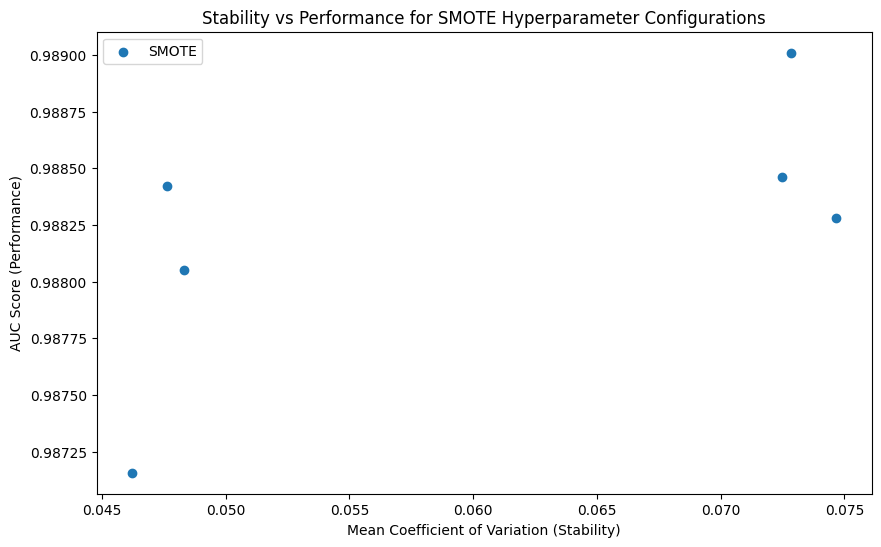

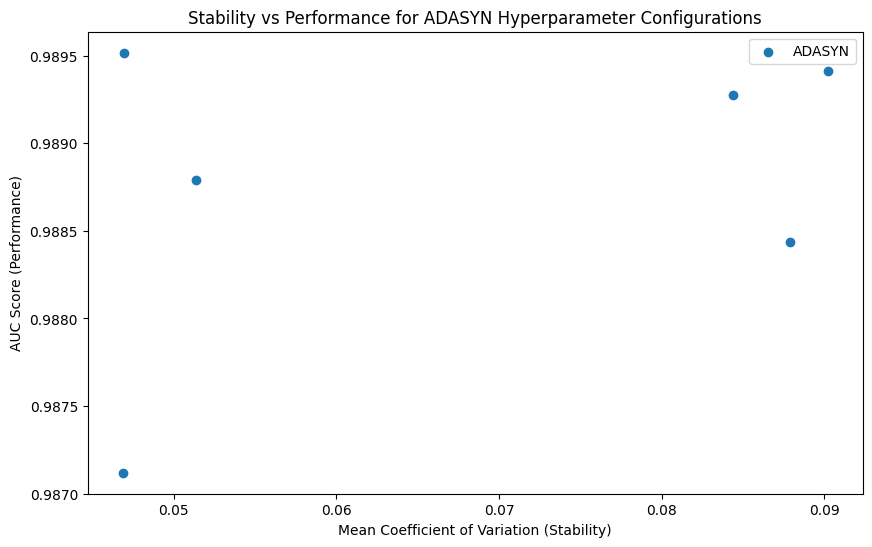

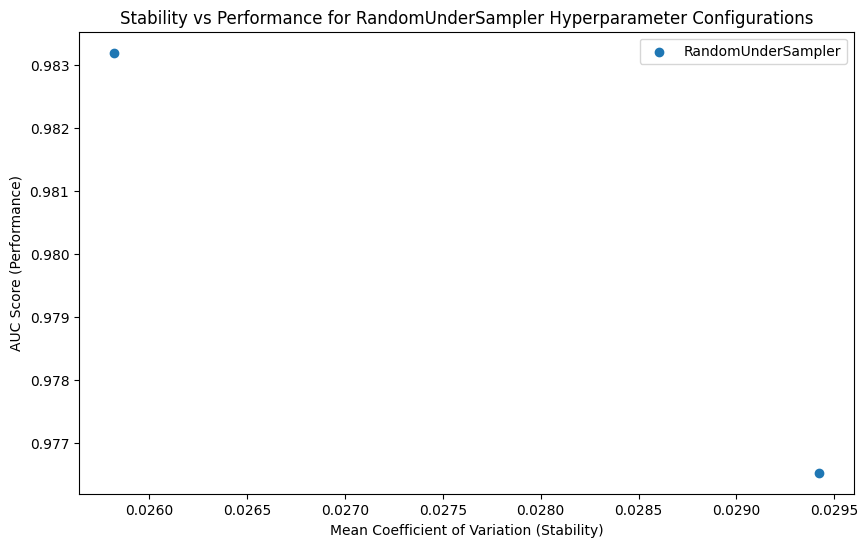

In [ ]:
import matplotlib.pyplot as plt

# Example plot for stability vs AUC
for method_name, stability_results in stability_results_per_method.items():
    mean_cvs = [result['mean_cv'] for result in stability_results]
    aucs = [result['auc'] for result in performance_results_per_method[method_name]]

    plt.figure(figsize=(10, 6))
    plt.scatter(mean_cvs, aucs, label=method_name)
    plt.xlabel('Mean Coefficient of Variation (Stability)')
    plt.ylabel('AUC Score (Performance)')
    plt.title(f'Stability vs Performance for {method_name} Hyperparameter Configurations')
    plt.legend()
    plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Define the best configurations for each sampling technique
best_sampling_configs = {
    'SMOTE': {
        'sampler': SMOTE(k_neighbors=3, sampling_strategy={0: 500, 1: 400, 2: 800}),  # Best performance configuration for SMOTE
    },
    'ADASYN': {
        'sampler': ADASYN(n_neighbors=5, sampling_strategy={0: 400, 1: 300, 2: 750}),  # Best performance configuration for ADASYN
    },
    'RandomUnderSampler': {
        'sampler': RandomUnderSampler(sampling_strategy={0: 250, 1: 200, 2: 350}),  # Best performance configuration for RandomUnderSampler
    }
}

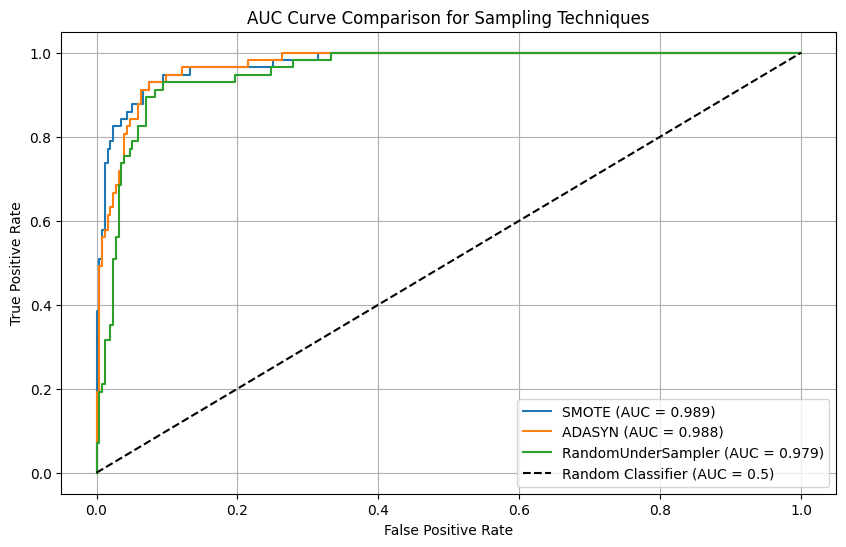

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Dictionary to store ROC curve data for each sampling technique
roc_results = {}

# Loop over each sampling technique and configuration
for method_name, best_config in best_sampling_configs.items():
    sampler = best_config['sampler']

    # Resample the data with the best configuration
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

    # Train the model
    xgb_model.fit(X_train_resampled, y_train_resampled)

    # Get predicted probabilities on the test set
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)  # Adjust `pos_label` for multi-class
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Store the results
    roc_results[method_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc_score
    }

# Plot the ROC curves for each sampling technique
plt.figure(figsize=(10, 6))

for method_name, result in roc_results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{method_name} (AUC = {result['auc']:.3f})")

# Plotting diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve Comparison for Sampling Techniques")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
import pickle
import os

# Define the directory path in Google Drive
save_dir = "/content/drive/MyDrive/RiskPaper"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the file paths
stability_results_file = os.path.join(save_dir, "stability_results_per_method.pkl")
performance_results_file = os.path.join(save_dir, "performance_results_per_method.pkl")

# Save the stability and performance results using pickle
with open(stability_results_file, "wb") as f:
    pickle.dump(stability_results_per_method, f)
with open(performance_results_file, "wb") as f:
    pickle.dump(performance_results_per_method, f)

print("Results have been saved successfully in Google Drive.")

Results have been saved successfully in Google Drive.


In [ ]:
import pickle
import os
import shap
import matplotlib.pyplot as plt

In [ ]:
# Define the directory path in Google Drive
save_dir = "/content/drive/MyDrive/RiskPaper"

# Define the file paths
stability_results_file = os.path.join(save_dir, "stability_results_per_method.pkl")
performance_results_file = os.path.join(save_dir, "performance_results_per_method.pkl")

# Load the stability and performance results using pickle
with open(stability_results_file, "rb") as f:
    stability_results_per_method = pickle.load(f)
with open(performance_results_file, "rb") as f:
    performance_results_per_method = pickle.load(f)

print("Results have been loaded successfully.")

Results have been loaded successfully.


In [ ]:
# XGBoost with SMOTE and ADASYN

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm  # Import tqdm for progress bars
import numpy as np

# Ensure tqdm is installed
!pip install tqdm

In [ ]:
# --- SMOTE Hyperparameter Tuning with Progress Bar ---
print("Starting SMOTE Hyperparameter Tuning...\n")

# Retrieve the best performance configuration for SMOTE
best_smote_config = {
    'k_neighbors': 3,
    'sampling_strategy': {0: 500, 1: 400, 2: 800}
}

# Perform data sampling using SMOTE
smote_sampler = SMOTE(
    k_neighbors=best_smote_config['k_neighbors'],
    sampling_strategy=best_smote_config['sampling_strategy']
)
X_train_resampled, y_train_resampled = smote_sampler.fit_resample(X_train, y_train)

# Define the hyperparameter distribution for XGBoost
param_dist_xgboost = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 1),
    'gamma': np.linspace(0, 5, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'reg_alpha': np.logspace(-3, 1, 5),
    'reg_lambda': np.logspace(-3, 1, 5)
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Perform hyperparameter tuning using RandomizedSearchCV for SMOTE with a progress bar
with tqdm(total=50, desc="Tuning XGBoost with SMOTE") as pbar:
    random_search_smote = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist_xgboost,
        n_iter=50,
        scoring='roc_auc_ovr',
        cv=5,
        verbose=2,
        random_state=42
    )
    random_search_smote.fit(X_train_resampled, y_train_resampled)
    pbar.update(50)

# Print the best parameters for SMOTE
print("Best XGBoost parameters after SMOTE:", random_search_smote.best_params_)

Starting SMOTE Hyperparameter Tuning...



Tuning XGBoost with SMOTE:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:49:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Tuning XGBoost with SMOTE: 100%|██████████| 50/50 [16:34<00:00, 19.89s/it]

Best XGBoost parameters after SMOTE: {'reg_lambda': 0.09999999999999999, 'reg_alpha': 0.001, 'max_depth': 10, 'learning_rate': 0.2677777777777778, 'gamma': 0.0, 'colsample_bytree': 0.75}


In [ ]:
# Print the best parameters for SMOTE
print("Best XGBoost parameters after SMOTE:", random_search_smote.best_params_)

Best XGBoost parameters after SMOTE: {'reg_lambda': 0.09999999999999999, 'reg_alpha': 0.001, 'max_depth': 10, 'learning_rate': 0.2677777777777778, 'gamma': 0.0, 'colsample_bytree': 0.75}


In [ ]:
# Evaluate the model with the best parameters on the original test set
best_xgb_smote = random_search_smote.best_estimator_
y_pred_smote = best_xgb_smote.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote, average='macro')
auc_smote = roc_auc_score(y_test, best_xgb_smote.predict_proba(X_test), multi_class='ovr')

print("SMOTE Performance Metrics:")
print(f"Accuracy: {accuracy_smote}")
print(f"F1 Score: {f1_smote}")
print(f"AUC: {auc_smote}")

SMOTE Performance Metrics:
Accuracy: 0.9326923076923077
F1 Score: 0.9068066806497996
AUC: 0.9876775286034118


In [ ]:
from imblearn.over_sampling import ADASYN
# --- ADASYN Hyperparameter Tuning with Progress Bar ---
print("\nStarting ADASYN Hyperparameter Tuning...\n")

# Retrieve the best performance configuration for ADASYN
best_adasyn_config = {
    'n_neighbors': 5,
    'sampling_strategy': {0: 400, 1: 300, 2: 750}
}

# Perform data sampling using ADASYN
adasyn_sampler = ADASYN(
    n_neighbors=best_adasyn_config['n_neighbors'],
    sampling_strategy=best_adasyn_config['sampling_strategy']
)
X_train_resampled, y_train_resampled = adasyn_sampler.fit_resample(X_train, y_train)

# Perform hyperparameter tuning using RandomizedSearchCV for ADASYN with a progress bar
with tqdm(total=50, desc="Tuning XGBoost with ADASYN") as pbar:
    random_search_adasyn = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist_xgboost,
        n_iter=50,
        scoring='roc_auc_ovr',
        cv=5,
        verbose=2,
        random_state=42
    )
    random_search_adasyn.fit(X_train_resampled, y_train_resampled)
    pbar.update(50)

# Print the best parameters for ADASYN
print("Best XGBoost parameters after ADASYN:", random_search_adasyn.best_params_)

# Evaluate the model with the best parameters on the original test set
best_xgb_adasyn = random_search_adasyn.best_estimator_
y_pred_adasyn = best_xgb_adasyn.predict(X_test)
accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
f1_adasyn = f1_score(y_test, y_pred_adasyn, average='macro')
auc_adasyn = roc_auc_score(y_test, best_xgb_adasyn.predict_proba(X_test), multi_class='ovr')

print("ADASYN Performance Metrics:")
print(f"Accuracy: {accuracy_adasyn}")
print(f"F1 Score: {f1_adasyn}")
print(f"AUC: {auc_adasyn}")


Starting ADASYN Hyperparameter Tuning...



Tuning XGBoost with ADASYN:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=10.0, reg_lambda=0.001; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:00:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.01, max_depth=9, reg_alpha=0.01, reg_lambda=1.0; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=0.01, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:01:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=6, reg_alpha=0.01, reg_lambda=10.0; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=5, reg_alpha=1.0, reg_lambda=0.001; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.1388888888888889, max_depth=5, reg_alpha=0.001, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:02:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.3, max_depth=9, reg_alpha=0.09999999999999999, reg_lambda=0.09999999999999999; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=3.75, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=1.0, reg_lambda=0.01; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=2.5, learning_rate=0.01, max_depth=8, reg_alpha=0.01, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.01, max_depth=3, reg_alpha=10.0, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1711111111111111, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2677777777777778, max_depth=6, reg_alpha=0.09999999999999999, reg_lambda=0.001; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.10666666666666666, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:05:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=2.5, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=0.09999999999999999, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=3.75, learning_rate=0.3, max_depth=3, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=5.0, learning_rate=0.1711111111111111, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=3.75, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=1.0, reg_lambda=1.0; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:06:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=1.0, reg_lambda=10.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=5.0, learning_rate=0.10666666666666666, max_depth=6, reg_alpha=1.0, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=3.75, learning_rate=0.042222222222222223, max_depth=10, reg_alpha=10.0, reg_lambda=0.01; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=3.75, learning_rate=0.23555555555555557, max_depth=6, reg_alpha=0.01, reg_lambda=0.001; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.23555555555555557, max_depth=4, reg_alpha=0.01, reg_lambda=10.0; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=2.5, learning_rate=0.2677777777777778, max_depth=5, reg_alpha=0.01, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:08:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1388888888888889, max_depth=8, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:09:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=10, reg_alpha=0.09999999999999999, reg_lambda=10.0; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=5.0, learning_rate=0.1711111111111111, max_depth=7, reg_alpha=1.0, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=2.5, learning_rate=0.2677777777777778, max_depth=9, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=10.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:10:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.20333333333333334, max_depth=5, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.001, reg_lambda=0.01; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.20333333333333334, max_depth=10, reg_alpha=1.0, reg_lambda=10.0; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:11:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.23555555555555557, max_depth=9, reg_alpha=0.01, reg_lambda=0.01; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=1.0, reg_lambda=0.001; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2677777777777778, max_depth=3, reg_alpha=0.01, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:12:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.875, gamma=0.0, learning_rate=0.10666666666666666, max_depth=8, reg_alpha=1.0, reg_lambda=0.001; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=2.5, learning_rate=0.07444444444444444, max_depth=7, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=0.0, learning_rate=0.2677777777777778, max_depth=10, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:13:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.10666666666666666, max_depth=4, reg_alpha=0.001, reg_lambda=0.09999999999999999; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.10666666666666666, max_depth=10, reg_alpha=1.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.20333333333333334, max_depth=7, reg_alpha=10.0, reg_lambda=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=10.0, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5.0, learning_rate=0.07444444444444444, max_depth=4, reg_alpha=0.01, reg_lambda=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.25, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=0.001, reg_lambda=0.01; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.625, gamma=0.0, learning_rate=0.1711111111111111, max_depth=3, reg_alpha=1.0, reg_lambda=0.01; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:16:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:16:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:16:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.75, gamma=1.25, learning_rate=0.3, max_depth=6, reg_alpha=10.0, reg_lambda=0.09999999999999999; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Tuning XGBoost with ADASYN: 100%|██████████| 50/50 [15:59<00:00, 19.20s/it]


Best XGBoost parameters after ADASYN: {'reg_lambda': 0.01, 'reg_alpha': 0.001, 'max_depth': 9, 'learning_rate': 0.23555555555555557, 'gamma': 0.0, 'colsample_bytree': 0.875}
ADASYN Performance Metrics:
Accuracy: 0.9391025641025641
F1 Score: 0.91545624586367
AUC: 0.9888816249821234


In [ ]:
# --- Comparison ---

print("\nComparison of SMOTE and ADASYN Performance Metrics:")
print(f"SMOTE - Accuracy: {accuracy_smote}, F1 Score: {f1_smote}, AUC: {auc_smote}")
print(f"ADASYN - Accuracy: {accuracy_adasyn}, F1 Score: {f1_adasyn}, AUC: {auc_adasyn}")


Comparison of SMOTE and ADASYN Performance Metrics:
SMOTE - Accuracy: 0.9326923076923077, F1 Score: 0.9068066806497996, AUC: 0.9876775286034118
ADASYN - Accuracy: 0.9391025641025641, F1 Score: 0.91545624586367, AUC: 0.9888816249821234


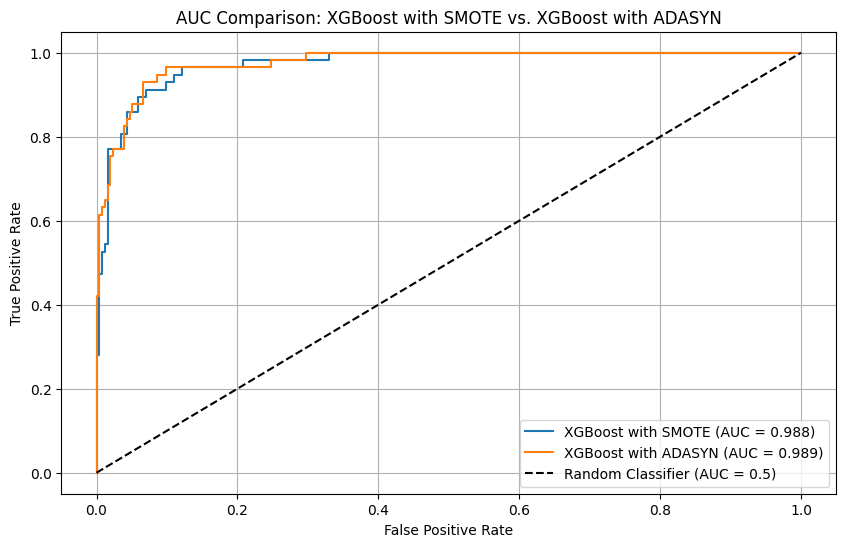

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Evaluate XGBoost with SMOTE ---

# Get predicted probabilities for the test set
y_pred_proba_XGBoost_SMOTE = best_xgb_smote.predict_proba(X_test)

# Calculate the ROC curve for each class and the overall AUC
fpr_XGBoost_SMOTE, tpr_XGBoost_SMOTE, _ = roc_curve(y_test, y_pred_proba_XGBoost_SMOTE[:, 1], pos_label=1)
auc_XGBoost_SMOTE = roc_auc_score(y_test, y_pred_proba_XGBoost_SMOTE, multi_class='ovr')

# --- Evaluate XGBoost with ADASYN ---

# Get predicted probabilities for the test set
y_pred_proba_XGBoost_ADASYN = best_xgb_adasyn.predict_proba(X_test)

# Calculate the ROC curve for each class and the overall AUC
fpr_XGBoost_ADASYN, tpr_XGBoost_ADASYN, _ = roc_curve(y_test, y_pred_proba_XGBoost_ADASYN[:, 1], pos_label=1)
auc_XGBoost_ADASYN = roc_auc_score(y_test, y_pred_proba_XGBoost_ADASYN, multi_class='ovr')

# --- Plot AUC Graph for XGBoost with SMOTE vs. ADASYN ---

plt.figure(figsize=(10, 6))

# Plot ROC curve for XGBoost with SMOTE
plt.plot(fpr_XGBoost_SMOTE, tpr_XGBoost_SMOTE, label=f"XGBoost with SMOTE (AUC = {auc_XGBoost_SMOTE:.3f})")

# Plot ROC curve for XGBoost with ADASYN
plt.plot(fpr_XGBoost_ADASYN, tpr_XGBoost_ADASYN, label=f"XGBoost with ADASYN (AUC = {auc_XGBoost_ADASYN:.3f})")

# Plotting the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")

# Graph labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Comparison: XGBoost with SMOTE vs. XGBoost with ADASYN")
plt.legend(loc="lower right")
plt.grid()
plt.show()

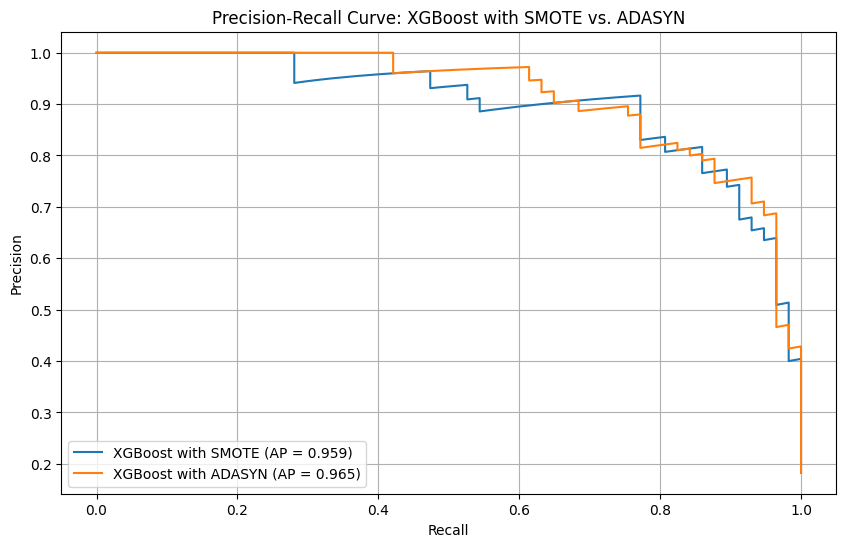

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# --- Precision-Recall Curve for XGBoost with SMOTE ---

# Get the predicted probabilities for each class in the test set
y_pred_proba_XGBoost_SMOTE = best_xgb_smote.predict_proba(X_test)

# Calculate the average precision score for multi-class classification
average_precision_XGBoost_SMOTE = average_precision_score(y_test, y_pred_proba_XGBoost_SMOTE, average='macro')

# --- Precision-Recall Curve for XGBoost with ADASYN ---

# Get the predicted probabilities for each class in the test set
y_pred_proba_XGBoost_ADASYN = best_xgb_adasyn.predict_proba(X_test)

# Calculate the average precision score for multi-class classification
average_precision_XGBoost_ADASYN = average_precision_score(y_test, y_pred_proba_XGBoost_ADASYN, average='macro')

# --- Plot Precision-Recall Curve ---
plt.figure(figsize=(10, 6))

# Note: The precision-recall curve for multi-class is more complex, but you can still plot
# precision and recall for a selected class. Here, we're using class 1 as an example.
precision_XGBoost_SMOTE, recall_XGBoost_SMOTE, _ = precision_recall_curve(y_test, y_pred_proba_XGBoost_SMOTE[:, 1], pos_label=1)
precision_XGBoost_ADASYN, recall_XGBoost_ADASYN, _ = precision_recall_curve(y_test, y_pred_proba_XGBoost_ADASYN[:, 1], pos_label=1)

plt.plot(recall_XGBoost_SMOTE, precision_XGBoost_SMOTE, label=f"XGBoost with SMOTE (AP = {average_precision_XGBoost_SMOTE:.3f})")
plt.plot(recall_XGBoost_ADASYN, precision_XGBoost_ADASYN, label=f"XGBoost with ADASYN (AP = {average_precision_XGBoost_ADASYN:.3f})")

# Graph labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: XGBoost with SMOTE vs. ADASYN")
plt.legend(loc="lower left")
plt.grid()
plt.show()

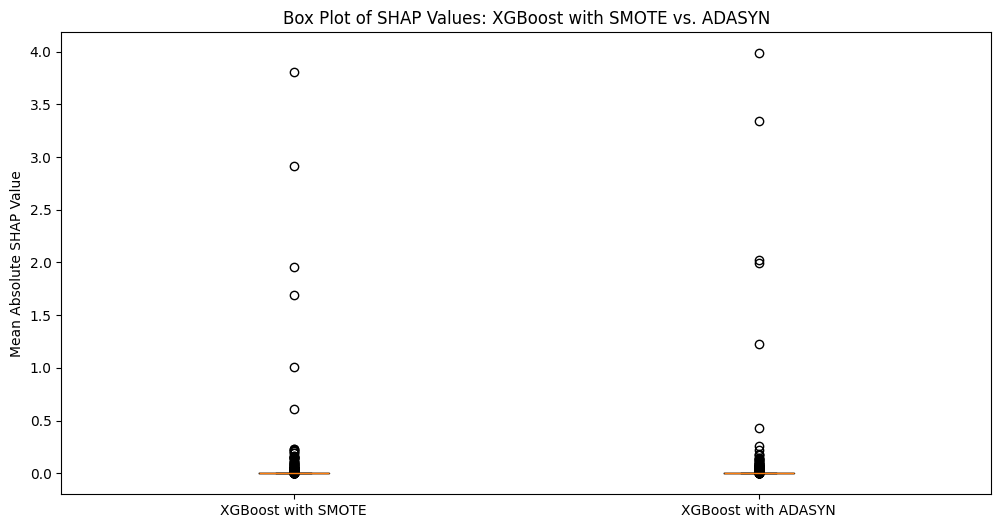

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# --- SHAP Value Calculation for XGBoost with SMOTE ---
explainer_XGBoost_SMOTE = shap.TreeExplainer(best_xgb_smote)
shap_values_XGBoost_SMOTE = explainer_XGBoost_SMOTE.shap_values(X_test)

# --- SHAP Value Calculation for XGBoost with ADASYN ---
explainer_XGBoost_ADASYN = shap.TreeExplainer(best_xgb_adasyn)
shap_values_XGBoost_ADASYN = explainer_XGBoost_ADASYN.shap_values(X_test)

# Calculate the mean absolute SHAP values across all samples for each feature
mean_abs_shap_values_XGBoost_SMOTE = np.mean(np.abs(shap_values_XGBoost_SMOTE), axis=0)
mean_abs_shap_values_XGBoost_ADASYN = np.mean(np.abs(shap_values_XGBoost_ADASYN), axis=0)

# Ensure the values are 1D for box plotting by flattening the arrays
mean_abs_shap_values_XGBoost_SMOTE = mean_abs_shap_values_XGBoost_SMOTE.flatten()
mean_abs_shap_values_XGBoost_ADASYN = mean_abs_shap_values_XGBoost_ADASYN.flatten()

# --- Plot the Box Plot ---
plt.figure(figsize=(12, 6))
plt.boxplot(
    [mean_abs_shap_values_XGBoost_SMOTE, mean_abs_shap_values_XGBoost_ADASYN],
    labels=["XGBoost with SMOTE", "XGBoost with ADASYN"]
)
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Box Plot of SHAP Values: XGBoost with SMOTE vs. ADASYN")
plt.show()

In [ ]:
# ADA

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# --- Define the Hyperparameter Distribution for AdaBoost ---
param_dist_adaboost = {
    'n_estimators': np.arange(50, 501, 50),               # Number of weak learners
    'learning_rate': np.linspace(0.01, 1.0, 10),          # Learning rate
    'estimator__max_depth': np.arange(1, 11, 1),          # Max depth of each decision tree
    'estimator__min_samples_split': np.arange(2, 21, 2),  # Min samples to split
    'estimator__min_samples_leaf': np.arange(1, 11, 1),   # Min samples at a leaf
    'algorithm': ['SAMME', 'SAMME.R']                     # AdaBoost algorithm type
}

# Initialize AdaBoost with DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier()
ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# --- Hyperparameter Tuning for AdaBoost with SMOTE ---
print("Starting AdaBoost Hyperparameter Tuning with SMOTE...")

# Perform data sampling using SMOTE
X_train_resampled_SMOTE, y_train_resampled_SMOTE = smote_sampler.fit_resample(X_train, y_train)

# Perform RandomizedSearchCV for AdaBoost after SMOTE
random_search_ada_smote = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_dist_adaboost,
    n_iter=50,  # Adjust as needed for time constraints
    scoring='roc_auc_ovr',
    cv=5,
    verbose=2,
    random_state=42
)
random_search_ada_smote.fit(X_train_resampled_SMOTE, y_train_resampled_SMOTE)

# Print the best parameters for AdaBoost with SMOTE
print("Best AdaBoost parameters after SMOTE:", random_search_ada_smote.best_params_)

Starting AdaBoost Hyperparameter Tuning with SMOTE...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  18.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  18.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  18.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  22.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  22.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  22.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  14.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  14.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  14.9s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  21.0s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  21.1s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  21.0s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  21.0s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimato

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  19.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  19.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  19.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  19.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  19.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  22.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  22.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  22.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  22.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  22.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  31.8s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  31.3s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  31.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  32.1s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=45

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  25.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  26.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  25.0s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   6.3s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   6.4s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   6.3s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   6.2s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=2

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  35.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  32.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  32.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  32.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  34.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  19.5s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  18.9s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  19.5s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  19.5s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   7.8s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.4s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.3s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.5s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.3s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  36.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  36.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  36.8s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  17.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  17.0s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  17.4s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  17.2s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=3

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  18.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  18.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  18.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  18.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  22.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   3.3s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  32.2s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  31.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  32.1s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  32.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimato

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=  10.1s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   8.5s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   8.5s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   8.6s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   8.5s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  12.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  14.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  13.7s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  19.7s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  18.9s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  19.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  19.3s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   4.3s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  17.5s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  17.3s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  17.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  17.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estima

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  20.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  19.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=  11.3s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  19.3s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  18.7s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  19.6s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  19.8s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=  11.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=  11.5s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   8.1s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   8.2s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   8.0s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   8.1s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; to

In [ ]:
# Print the best parameters for AdaBoost with SMOTE
print("Best AdaBoost parameters after SMOTE:", random_search_ada_smote.best_params_)

Best AdaBoost parameters after SMOTE: {'n_estimators': 250, 'learning_rate': 0.56, 'estimator__min_samples_split': 14, 'estimator__min_samples_leaf': 5, 'estimator__max_depth': 9, 'algorithm': 'SAMME'}


In [ ]:
# --- Hyperparameter Tuning for AdaBoost with ADASYN ---
print("\nStarting AdaBoost Hyperparameter Tuning with ADASYN...")

# Perform data sampling using ADASYN
X_train_resampled_ADASYN, y_train_resampled_ADASYN = adasyn_sampler.fit_resample(X_train, y_train)

# Perform RandomizedSearchCV for AdaBoost after ADASYN
random_search_ada_adasyn = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_dist_adaboost,
    n_iter=50,  # Adjust as needed for time constraints
    scoring='roc_auc_ovr',
    cv=5,
    verbose=2,
    random_state=42
)
random_search_ada_adasyn.fit(X_train_resampled_ADASYN, y_train_resampled_ADASYN)

# Print the best parameters for AdaBoost with ADASYN
print("Best AdaBoost parameters after ADASYN:", random_search_ada_adasyn.best_params_)


Starting AdaBoost Hyperparameter Tuning with ADASYN...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.56, n_estimators=450; total time=  15.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  18.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  17.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  17.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  17.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.67, n_estimators=400; total time=  18.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=2, estimator__min_samples_split=20, learning_rate=0.34, n_estimators=150; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=14, learning_rate=1.0, n_estimators=250; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  13.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=18, learning_rate=0.78, n_estimators=500; total time=  13.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  12.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=450; total time=  12.2s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  17.4s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  17.4s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  17.5s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimators=350; total time=  17.3s
[CV] END algorithm=SAMME, estimator__max_depth=6, estimator__min_samples_leaf=5, estimator__min_samples_split=18, learning_rate=0.89, n_estimato

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=8, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=400; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  18.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  18.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=9, estimator__min_samples_split=6, learning_rate=0.67, n_estimators=350; total time=  18.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  26.5s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  26.0s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  26.3s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=450; total time=  26.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=1.0, n_estimators=45

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=400; total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=7, estimator__min_samples_split=8, learning_rate=0.23, n_estimators=250; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=8, estimator__min_samples_leaf=6, estimator__min_samples_split=6, learning_rate=0.01, n_estimators=200; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  21.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=0.34, n_estimators=300; total time=  22.4s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   5.3s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   5.3s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   5.5s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=200; total time=   5.3s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=2

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  26.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  27.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  28.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  27.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=5, estimator__min_samples_split=2, learning_rate=0.23, n_estimators=400; total time=  28.0s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  16.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  15.7s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  16.3s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimators=300; total time=  16.4s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=5, estimator__min_samples_split=20, learning_rate=0.23, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=10, estimator__min_samples_split=2, learning_rate=0.45, n_estimators=100; total time=   6.6s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.0s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.0s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.0s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=100; total time=   2.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.12, n_estimators=

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=1, estimator__min_samples_leaf=4, estimator__min_samples_split=8, learning_rate=0.56, n_estimators=300; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=16, learning_rate=0.78, n_estimators=500; total time=  29.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  14.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  14.0s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  14.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=300; total time=  14.2s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.01, n_estimators=3

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=10, estimator__min_samples_split=16, learning_rate=0.67, n_estimators=300; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  18.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  18.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=14, learning_rate=0.01, n_estimators=450; total time=  18.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=6, estimator__min_samples_leaf=7, estimator__min_samples_split=16, learning_rate=0.34, n_estimators=50; total time=   2.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  26.9s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  26.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  26.7s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimators=450; total time=  27.1s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=10, learning_rate=0.78, n_estimato

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  13.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=3, estimator__min_samples_split=12, learning_rate=0.34, n_estimators=400; total time=  13.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__min_samples_split=12, learning_rate=0.01, n_estimators=200; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=4, estimator__min_samples_leaf=1, estimator__min_samples_split=12, learning_rate=0.23, n_estimators=200; total time=   8.4s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   7.4s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   7.2s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   7.3s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimators=400; total time=   7.4s
[CV] END algorithm=SAMME, estimator__max_depth=1, estimator__min_samples_leaf=3, estimator__min_samples_split=16, learning_rate=0.45, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=4, estimator__min_samples_split=18, learning_rate=0.56, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  11.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  11.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.23, n_estimators=150; total time=  11.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  16.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  15.7s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  16.0s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimators=300; total time=  16.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=6, estimator__min_samples_split=16, learning_rate=0.23, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=3, estimator__min_samples_leaf=10, estimator__min_samples_split=20, learning_rate=0.89, n_estimators=100; total time=   3.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  14.8s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  14.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  14.8s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estimators=250; total time=  14.6s
[CV] END algorithm=SAMME, estimator__max_depth=9, estimator__min_samples_leaf=5, estimator__min_samples_split=14, learning_rate=0.56, n_estima

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  16.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  16.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=7, estimator__min_samples_leaf=7, estimator__min_samples_split=18, learning_rate=0.45, n_estimators=300; total time=  16.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=10, estimator__min_samples_split=8, learning_rate=0.45, n_estimators=350; total time=   9.5s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  16.3s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  16.0s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  16.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimators=300; total time=  16.2s
[CV] END algorithm=SAMME, estimator__max_depth=7, estimator__min_samples_leaf=8, estimator__min_samples_split=10, learning_rate=0.34, n_estimat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, estimator__max_depth=2, estimator__min_samples_leaf=7, estimator__min_samples_split=6, learning_rate=0.12, n_estimators=350; total time=   9.4s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   6.9s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   6.7s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   6.7s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; total time=   6.9s
[CV] END algorithm=SAMME, estimator__max_depth=2, estimator__min_samples_leaf=2, estimator__min_samples_split=8, learning_rate=1.0, n_estimators=250; to

In [ ]:
# Print the best parameters for AdaBoost with ADASYN
print("Best AdaBoost parameters after ADASYN:", random_search_ada_adasyn.best_params_)

Best AdaBoost parameters after ADASYN: {'n_estimators': 450, 'learning_rate': 0.78, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 5, 'estimator__max_depth': 9, 'algorithm': 'SAMME'}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Retrieve the Best AdaBoost Models ---
best_ada_smote = random_search_ada_smote.best_estimator_
best_ada_adasyn = random_search_ada_adasyn.best_estimator_

# --- Predictions and Metrics Calculation for AdaBoost with SMOTE ---

# Predict on the test set
y_pred_AdaBoost_SMOTE = best_ada_smote.predict(X_test)
y_pred_proba_AdaBoost_SMOTE = best_ada_smote.predict_proba(X_test)  # Get predicted probabilities

# Calculate metrics for SMOTE
accuracy_AdaBoost_SMOTE = accuracy_score(y_test, y_pred_AdaBoost_SMOTE)
f1_AdaBoost_SMOTE = f1_score(y_test, y_pred_AdaBoost_SMOTE, average='macro')
auc_AdaBoost_SMOTE = roc_auc_score(y_test, y_pred_proba_AdaBoost_SMOTE, multi_class='ovr')

# --- Predictions and Metrics Calculation for AdaBoost with ADASYN ---

# Predict on the test set
y_pred_AdaBoost_ADASYN = best_ada_adasyn.predict(X_test)
y_pred_proba_AdaBoost_ADASYN = best_ada_adasyn.predict_proba(X_test)  # Get predicted probabilities

# Calculate metrics for ADASYN
accuracy_AdaBoost_ADASYN = accuracy_score(y_test, y_pred_AdaBoost_ADASYN)
f1_AdaBoost_ADASYN = f1_score(y_test, y_pred_AdaBoost_ADASYN, average='macro')
auc_AdaBoost_ADASYN = roc_auc_score(y_test, y_pred_proba_AdaBoost_ADASYN, multi_class='ovr')

# --- Print the Comparison of Performance Metrics ---

print("\nComparison of SMOTE and ADASYN Performance Metrics for AdaBoost:")
print(f"AdaBoost with SMOTE - Accuracy: {accuracy_AdaBoost_SMOTE:.3f}, F1 Score: {f1_AdaBoost_SMOTE:.3f}, AUC: {auc_AdaBoost_SMOTE:.3f}")
print(f"AdaBoost with ADASYN - Accuracy: {accuracy_AdaBoost_ADASYN:.3f}, F1 Score: {f1_AdaBoost_ADASYN:.3f}, AUC: {auc_AdaBoost_ADASYN:.3f}")


Comparison of SMOTE and ADASYN Performance Metrics for AdaBoost:
AdaBoost with SMOTE - Accuracy: 0.939, F1 Score: 0.914, AUC: 0.989
AdaBoost with ADASYN - Accuracy: 0.933, F1 Score: 0.906, AUC: 0.988


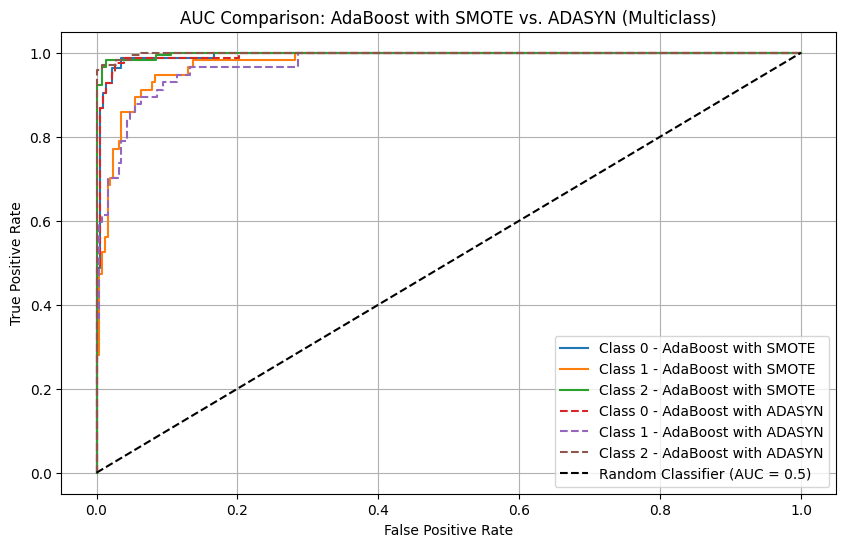

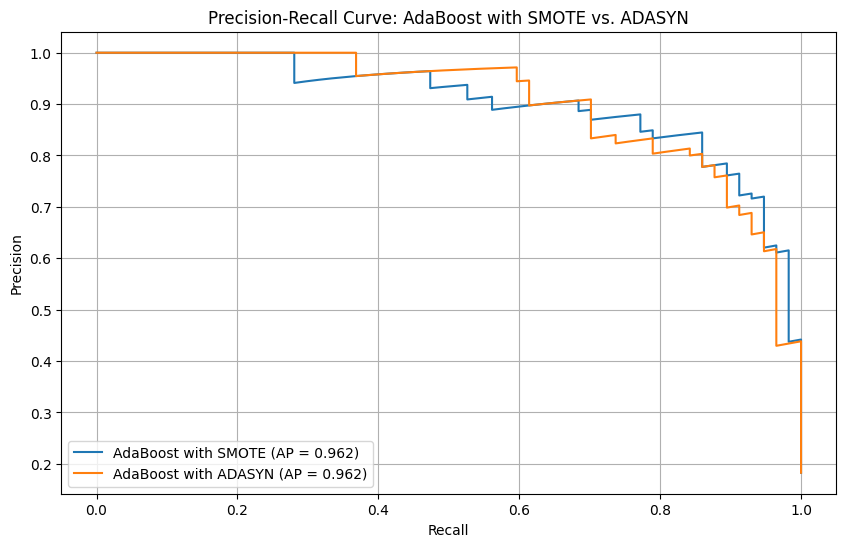

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import shap
import numpy as np

# --- Evaluation and Metrics Calculation ---

# Best AdaBoost model from RandomizedSearchCV
best_ada_smote = random_search_ada_smote.best_estimator_
best_ada_adasyn = random_search_ada_adasyn.best_estimator_

# Get predicted probabilities for the test set
y_pred_proba_AdaBoost_SMOTE = best_ada_smote.predict_proba(X_test)
y_pred_proba_AdaBoost_ADASYN = best_ada_adasyn.predict_proba(X_test)

# Calculate AUC for each model
auc_AdaBoost_SMOTE = roc_auc_score(y_test, y_pred_proba_AdaBoost_SMOTE, multi_class='ovr')
auc_AdaBoost_ADASYN = roc_auc_score(y_test, y_pred_proba_AdaBoost_ADASYN, multi_class='ovr')

# Calculate Precision-Recall and average precision for each model
precision_AdaBoost_SMOTE, recall_AdaBoost_SMOTE, _ = precision_recall_curve(y_test, y_pred_proba_AdaBoost_SMOTE[:, 1], pos_label=1)
average_precision_AdaBoost_SMOTE = average_precision_score(y_test, y_pred_proba_AdaBoost_SMOTE, average='macro')

precision_AdaBoost_ADASYN, recall_AdaBoost_ADASYN, _ = precision_recall_curve(y_test, y_pred_proba_AdaBoost_ADASYN[:, 1], pos_label=1)
average_precision_AdaBoost_ADASYN = average_precision_score(y_test, y_pred_proba_AdaBoost_ADASYN, average='macro')

# --- AUC Plot ---

plt.figure(figsize=(10, 6))

# Loop through each class and calculate the ROC curve
for i in range(y_pred_proba_AdaBoost_SMOTE.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_AdaBoost_SMOTE[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f"Class {i} - AdaBoost with SMOTE")

for i in range(y_pred_proba_AdaBoost_ADASYN.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_AdaBoost_ADASYN[:, i], pos_label=i)
    plt.plot(fpr, tpr, linestyle='--', label=f"Class {i} - AdaBoost with ADASYN")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Comparison: AdaBoost with SMOTE vs. ADASYN (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall (PR) Curve ---
plt.figure(figsize=(10, 6))
plt.plot(recall_AdaBoost_SMOTE, precision_AdaBoost_SMOTE, label=f"AdaBoost with SMOTE (AP = {average_precision_AdaBoost_SMOTE:.3f})")
plt.plot(recall_AdaBoost_ADASYN, precision_AdaBoost_ADASYN, label=f"AdaBoost with ADASYN (AP = {average_precision_AdaBoost_ADASYN:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: AdaBoost with SMOTE vs. ADASYN")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [ ]:
# ANN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_ann = {
    'learning_rate_init': np.logspace(-4, -1, 10),  # Learning rate
    'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 128), (64, 128, 64)],  # Number of layers and neurons
    'activation': ['relu', 'tanh', 'logistic'],    # Activation function
    'batch_size': np.arange(32, 257, 32),          # Batch size
    'max_iter': np.arange(100, 1001, 100),         # Number of epochs
    'alpha': np.logspace(-4, -1, 10)               # L2 regularization (alpha)
}

# --- SMOTE Hyperparameter Tuning with Progress Bar ---
print("Starting SMOTE Hyperparameter Tuning for ANN...\n")

# Perform data sampling using SMOTE
smote_sampler = SMOTE(
    k_neighbors=best_smote_config['k_neighbors'],
    sampling_strategy=best_smote_config['sampling_strategy']
)
X_train_smote, y_train_smote = smote_sampler.fit_resample(X_train, y_train)

# Initialize MLPClassifier for ANN
ann_model = MLPClassifier(random_state=42)

# Perform hyperparameter tuning using RandomizedSearchCV for ANN with SMOTE
with tqdm(total=50, desc="Tuning ANN with SMOTE") as pbar:
    random_search_ann_smote = RandomizedSearchCV(
        estimator=ann_model,
        param_distributions=param_dist_ann,
        n_iter=50,
        scoring='roc_auc_ovr',
        cv=5,
        verbose=2,
        random_state=42
    )
    random_search_ann_smote.fit(X_train_smote, y_train_smote)
    pbar.update(50)

# Print the best parameters for ANN with SMOTE
print("Best ANN parameters after SMOTE:", random_search_ann_smote.best_params_)

Starting SMOTE Hyperparameter Tuning for ANN...



Tuning ANN with SMOTE:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   2.0s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   5.5s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=  12.4s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   1.3s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   2.5s
[CV] END activation=relu, alpha=9.999999999999999e-05, batch_size=64, hidden_layer_sizes=(128, 128), learning_rate_init=0.01, max_iter=100; total time=  

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  41.6s
[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  34.0s
[CV] END activation=tanh, alpha=0.001, batch_size=128, hidden_layer_sizes=(64, 64), learning_rate_init=9.999999999999999e-05, max_iter=800; total time=   5.4s
[CV] END activation=tanh, alpha=0.001, batch_size=128, hidden_layer_sizes=(64, 64), learning_rate_init=9.999999999999999e-05, max_iter=800; total time=   5.3s
[CV] END activation=tanh, alpha=0.001, batch_size=128, hidden_layer_sizes=(64, 64), learning_rate_init=9.999999999999999e-05, max_iter=800; total time=   6.2s
[CV] END activation=tanh, alpha=0.001, batch_size=128, hidden_layer_sizes=(64, 64), learning_rate_init=9.999999999999999e-05, max_iter=800; total time=   9.4s
[CV] END a

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.021544346900318822, batch_size=64, hidden_layer_sizes=(128,), learning_rate_init=0.09999999999999999, max_iter=400; total time=  56.8s
[CV] END activation=relu, alpha=0.021544346900318822, batch_size=64, hidden_layer_sizes=(128,), learning_rate_init=0.09999999999999999, max_iter=400; total time=  52.1s
[CV] END activation=relu, alpha=0.021544346900318822, batch_size=64, hidden_layer_sizes=(128,), learning_rate_init=0.09999999999999999, max_iter=400; total time=  52.6s
[CV] END activation=tanh, alpha=0.021544346900318822, batch_size=256, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.001, max_iter=300; total time=   1.4s
[CV] END activation=tanh, alpha=0.021544346900318822, batch_size=256, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.001, max_iter=300; total time=   1.6s
[CV] END activation=tanh, alpha=0.021544346900318822, batch_size=256, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.001, max_iter=300; total time=   1.6s
[CV]

Tuning ANN with SMOTE: 100%|██████████| 50/50 [27:36<00:00, 33.14s/it]

Best ANN parameters after SMOTE: {'max_iter': 400, 'learning_rate_init': 9.999999999999999e-05, 'hidden_layer_sizes': (128, 128), 'batch_size': 192, 'alpha': 0.01, 'activation': 'tanh'}


In [ ]:
# --- ADASYN Hyperparameter Tuning with Progress Bar ---
print("\nStarting ADASYN Hyperparameter Tuning for ANN...\n")

# Perform data sampling using ADASYN
adasyn_sampler = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn_sampler.fit_resample(X_train, y_train)

# Perform hyperparameter tuning using RandomizedSearchCV for ANN with ADASYN
with tqdm(total=50, desc="Tuning ANN with ADASYN") as pbar:
    random_search_ann_adasyn = RandomizedSearchCV(
        estimator=ann_model,
        param_distributions=param_dist_ann,
        n_iter=50,
        scoring='roc_auc_ovr',
        cv=5,
        verbose=2,
        random_state=42
    )
    random_search_ann_adasyn.fit(X_train_adasyn, y_train_adasyn)
    pbar.update(50)

# Print the best parameters for ANN with ADASYN
print("Best ANN parameters after ADASYN:", random_search_ann_adasyn.best_params_)


Starting ADASYN Hyperparameter Tuning for ANN...



Tuning ANN with ADASYN:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   1.5s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   1.5s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   5.0s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   2.2s
[CV] END activation=relu, alpha=0.001, batch_size=256, hidden_layer_sizes=(64, 64), learning_rate_init=0.09999999999999999, max_iter=600; total time=   4.7s
[CV] END activation=relu, alpha=9.999999999999999e-05, batch_size=64, hidden_layer_sizes=(128, 128), learning_rate_init=0.01, max_iter=100; total time=  

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09999999999999999, batch_size=96, hidden_layer_sizes=(128,), learning_rate_init=0.09999999999999999, max_iter=500; total time= 1.1min
[CV] END activation=relu, alpha=0.09999999999999999, batch_size=96, hidden_layer_sizes=(128,), learning_rate_init=0.09999999999999999, max_iter=500; total time= 1.0min
[CV] END activation=logistic, alpha=0.00021544346900318845, batch_size=224, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.09999999999999999, max_iter=900; total time=   1.9s
[CV] END activation=logistic, alpha=0.00021544346900318845, batch_size=224, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.09999999999999999, max_iter=900; total time=   3.7s
[CV] END activation=logistic, alpha=0.00021544346900318845, batch_size=224, hidden_layer_sizes=(64, 128, 64), learning_rate_init=0.09999999999999999, max_iter=900; total time=   1.9s
[CV] END activation=logistic, alpha=0.00021544346900318845, batch_size=224, hidden_layer_sizes=(64, 128, 64), learn

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  49.4s
[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  25.2s
[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  12.4s
[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=  20.7s
[CV] END activation=logistic, alpha=9.999999999999999e-05, batch_size=224, hidden_layer_sizes=(128,), learning_rate_init=9.999999999999999e-05, max_iter=500; total time=   9.8s
[CV] END activation=tanh, alpha=0.001, batch_size=128, hidden_layer_sizes=(64, 64), learning_rate_init=9.9999999999

Tuning ANN with ADASYN: 100%|██████████| 50/50 [32:56<00:00, 39.52s/it]

Best ANN parameters after ADASYN: {'max_iter': 600, 'learning_rate_init': 9.999999999999999e-05, 'hidden_layer_sizes': (128, 128), 'batch_size': 96, 'alpha': 0.00021544346900318845, 'activation': 'logistic'}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# --- Evaluation and Metrics Calculation ---

# Best ANN models from RandomizedSearchCV
best_ann_smote = random_search_ann_smote.best_estimator_
best_ann_adasyn = random_search_ann_adasyn.best_estimator_

# Predict on the test set using the best ANN models
y_pred_ANN_SMOTE = best_ann_smote.predict(X_test)
y_pred_proba_ANN_SMOTE = best_ann_smote.predict_proba(X_test)

y_pred_ANN_ADASYN = best_ann_adasyn.predict(X_test)
y_pred_proba_ANN_ADASYN = best_ann_adasyn.predict_proba(X_test)

# Calculate metrics for SMOTE
accuracy_ANN_SMOTE = accuracy_score(y_test, y_pred_ANN_SMOTE)
f1_ANN_SMOTE = f1_score(y_test, y_pred_ANN_SMOTE, average='macro')
auc_ANN_SMOTE = roc_auc_score(y_test, y_pred_proba_ANN_SMOTE, multi_class='ovr')

# Calculate metrics for ADASYN
accuracy_ANN_ADASYN = accuracy_score(y_test, y_pred_ANN_ADASYN)
f1_ANN_ADASYN = f1_score(y_test, y_pred_ANN_ADASYN, average='macro')
auc_ANN_ADASYN = roc_auc_score(y_test, y_pred_proba_ANN_ADASYN, multi_class='ovr')

# --- Print Comparison Metrics ---
print("\nComparison of ANN Performance Metrics:")
print(f"SMOTE - Accuracy: {accuracy_ANN_SMOTE}, F1 Score: {f1_ANN_SMOTE}, AUC: {auc_ANN_SMOTE}")
print(f"ADASYN - Accuracy: {accuracy_ANN_ADASYN}, F1 Score: {f1_ANN_ADASYN}, AUC: {auc_ANN_ADASYN}")


Comparison of ANN Performance Metrics:
SMOTE - Accuracy: 0.9775641025641025, F1 Score: 0.9672830725462304, AUC: 0.9924989518016987
ADASYN - Accuracy: 0.8974358974358975, F1 Score: 0.8785385998587124, AUC: 0.9821390233336088


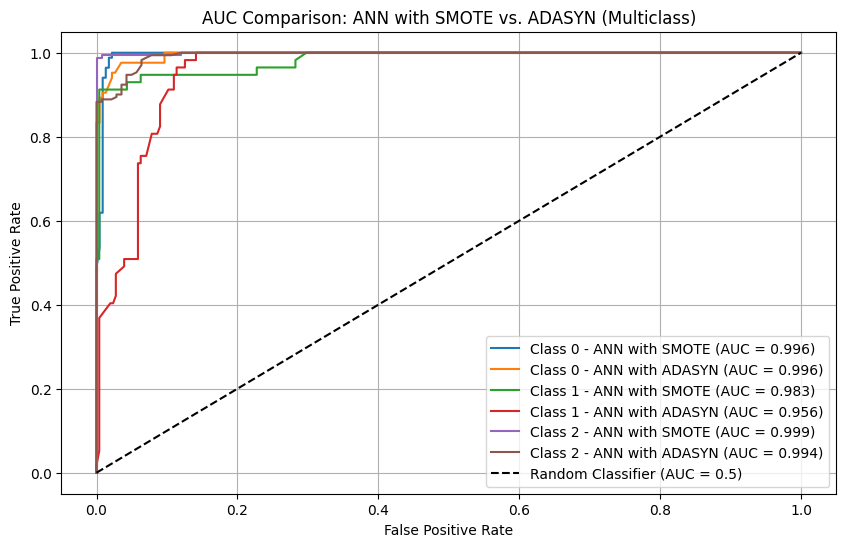

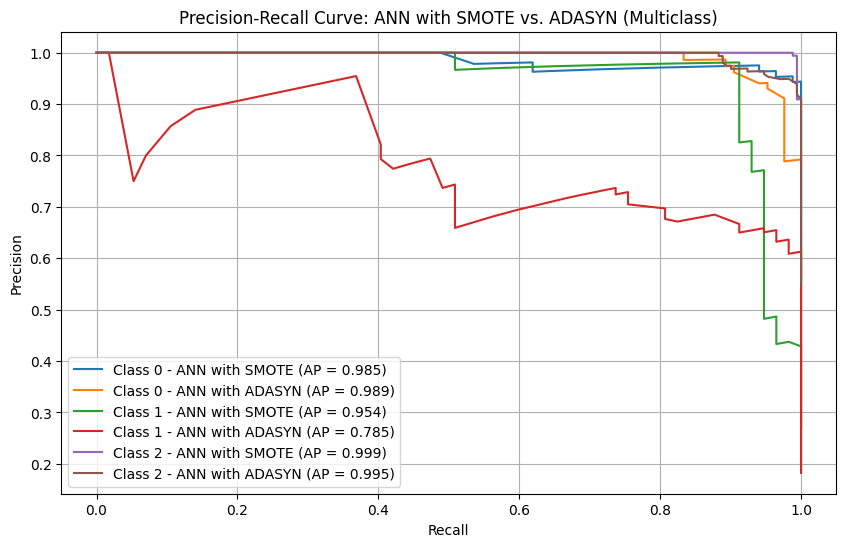

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# --- Binarize the Labels for Multiclass ---
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# --- AUC Plot for Multiclass ---
plt.figure(figsize=(10, 6))

# Loop through each class and plot the AUC curves
for i in range(y_test_binarized.shape[1]):
    # ROC Curve for ANN with SMOTE
    fpr_smote, tpr_smote, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_ANN_SMOTE[:, i])
    auc_smote = roc_auc_score(y_test_binarized[:, i], y_pred_proba_ANN_SMOTE[:, i])
    plt.plot(fpr_smote, tpr_smote, label=f"Class {i} - ANN with SMOTE (AUC = {auc_smote:.3f})")

    # ROC Curve for ANN with ADASYN
    fpr_adasyn, tpr_adasyn, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_ANN_ADASYN[:, i])
    auc_adasyn = roc_auc_score(y_test_binarized[:, i], y_pred_proba_ANN_ADASYN[:, i])
    plt.plot(fpr_adasyn, tpr_adasyn, label=f"Class {i} - ANN with ADASYN (AUC = {auc_adasyn:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Comparison: ANN with SMOTE vs. ADASYN (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall (PR) Curve for Multiclass ---
plt.figure(figsize=(10, 6))

# Loop through each class and plot the PR curves
for i in range(y_test_binarized.shape[1]):
    # PR Curve for ANN with SMOTE
    precision_smote, recall_smote, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_ANN_SMOTE[:, i])
    avg_precision_smote = average_precision_score(y_test_binarized[:, i], y_pred_proba_ANN_SMOTE[:, i])
    plt.plot(recall_smote, precision_smote, label=f"Class {i} - ANN with SMOTE (AP = {avg_precision_smote:.3f})")

    # PR Curve for ANN with ADASYN
    precision_adasyn, recall_adasyn, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_ANN_ADASYN[:, i])
    avg_precision_adasyn = average_precision_score(y_test_binarized[:, i], y_pred_proba_ANN_ADASYN[:, i])
    plt.plot(recall_adasyn, precision_adasyn, label=f"Class {i} - ANN with ADASYN (AP = {avg_precision_adasyn:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: ANN with SMOTE vs. ADASYN (Multiclass)")
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [ ]:
import joblib
import numpy as np
import json

# Define your Google Drive path
drive_path = '/content/drive/My Drive/RiskPaper/'  # Replace 'YourProjectFolder' with your folder name

# Save models
joblib.dump(best_xgb_smote, drive_path + 'best_xgb_smote.pkl')
joblib.dump(best_xgb_adasyn, drive_path + 'best_xgb_adasyn.pkl')
joblib.dump(best_ada_smote, drive_path + 'best_ada_smote.pkl')
joblib.dump(best_ada_adasyn, drive_path + 'best_ada_adasyn.pkl')
joblib.dump(best_ann_smote, drive_path + 'best_ann_smote.pkl')
joblib.dump(best_ann_adasyn, drive_path + 'best_ann_adasyn.pkl')

# Save resampled datasets
np.save(drive_path + 'X_train_smote.npy', X_train_smote)
np.save(drive_path + 'y_train_smote.npy', y_train_smote)
np.save(drive_path + 'X_train_adasyn.npy', X_train_adasyn)
np.save(drive_path + 'y_train_adasyn.npy', y_train_adasyn)

# Save hyperparameter search results
joblib.dump(random_search_smote, drive_path + 'random_search_xgb_smote.pkl')
joblib.dump(random_search_adasyn, drive_path + 'random_search_xgb_adasyn.pkl')
joblib.dump(random_search_ada_smote, drive_path + 'random_search_ada_smote.pkl')
joblib.dump(random_search_ada_adasyn, drive_path + 'random_search_ada_adasyn.pkl')
joblib.dump(random_search_ann_smote, drive_path + 'random_search_ann_smote.pkl')
joblib.dump(random_search_ann_adasyn, drive_path + 'random_search_ann_adasyn.pkl')

# Save metrics
metrics = {
    "XGBoost_SMOTE": {"accuracy": accuracy_smote, "f1": f1_smote, "auc": auc_smote},
    "XGBoost_ADASYN": {"accuracy": accuracy_adasyn, "f1": f1_adasyn, "auc": auc_adasyn},
    "AdaBoost_SMOTE": {"accuracy": accuracy_AdaBoost_SMOTE, "f1": f1_AdaBoost_SMOTE, "auc": auc_AdaBoost_SMOTE},
    "AdaBoost_ADASYN": {"accuracy": accuracy_AdaBoost_ADASYN, "f1": f1_AdaBoost_ADASYN, "auc": auc_AdaBoost_ADASYN},
    "ANN_SMOTE": {"accuracy": accuracy_ANN_SMOTE, "f1": f1_ANN_SMOTE, "auc": auc_ANN_SMOTE},
    "ANN_ADASYN": {"accuracy": accuracy_ANN_ADASYN, "f1": f1_ANN_ADASYN, "auc": auc_ANN_ADASYN}
}
with open(drive_path + 'metrics.json', 'w') as f:
    json.dump(metrics, f)

In [ ]:
import joblib
import numpy as np
import json

# Define your Google Drive path
drive_path = '/content/drive/My Drive/RiskPaper/'  # Make sure this path matches where you saved your files

# Load models
best_xgb_smote = joblib.load(drive_path + 'best_xgb_smote.pkl')
best_xgb_adasyn = joblib.load(drive_path + 'best_xgb_adasyn.pkl')
best_ada_smote = joblib.load(drive_path + 'best_ada_smote.pkl')
best_ada_adasyn = joblib.load(drive_path + 'best_ada_adasyn.pkl')
best_ann_smote = joblib.load(drive_path + 'best_ann_smote.pkl')
best_ann_adasyn = joblib.load(drive_path + 'best_ann_adasyn.pkl')

# Load resampled datasets with allow_pickle=True
X_train_smote = np.load(drive_path + 'X_train_smote.npy', allow_pickle=True)
y_train_smote = np.load(drive_path + 'y_train_smote.npy', allow_pickle=True)
X_train_adasyn = np.load(drive_path + 'X_train_adasyn.npy', allow_pickle=True)
y_train_adasyn = np.load(drive_path + 'y_train_adasyn.npy', allow_pickle=True)

# Load hyperparameter search results
random_search_xgb_smote = joblib.load(drive_path + 'random_search_xgb_smote.pkl')
random_search_xgb_adasyn = joblib.load(drive_path + 'random_search_xgb_adasyn.pkl')
random_search_ada_smote = joblib.load(drive_path + 'random_search_ada_smote.pkl')
random_search_ada_adasyn = joblib.load(drive_path + 'random_search_ada_adasyn.pkl')
random_search_ann_smote = joblib.load(drive_path + 'random_search_ann_smote.pkl')
random_search_ann_adasyn = joblib.load(drive_path + 'random_search_ann_adasyn.pkl')

# Load metrics
with open(drive_path + 'metrics.json', 'r') as f:
    metrics = json.load(f)

# Print metrics to verify they loaded correctly
print(metrics)

{'XGBoost_SMOTE': {'accuracy': 0.9326923076923077, 'f1': 0.9068066806497996, 'auc': 0.9992534527808884}, 'XGBoost_ADASYN': {'accuracy': 0.9391025641025641, 'f1': 0.91545624586367, 'auc': 0.9942142590518851}, 'AdaBoost_SMOTE': {'accuracy': 0.9391025641025641, 'f1': 0.9142447765510345, 'auc': 0.9893107110124545}, 'AdaBoost_ADASYN': {'accuracy': 0.9326923076923077, 'f1': 0.9062876935553089, 'auc': 0.9880810922104315}, 'ANN_SMOTE': {'accuracy': 0.9775641025641025, 'f1': 0.9672830725462304, 'auc': 0.9924989518016987}, 'ANN_ADASYN': {'accuracy': 0.8974358974358975, 'f1': 0.8785385998587124, 'auc': 0.9821390233336088}}


In [ ]:
# Line chart of averaged SRA values for SHAP

In [ ]:
class_counts = df["Risk_Level"].value_counts()
print(class_counts)

Risk_Level
2    861
0    432
1    265
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from scipy.stats import spearmanr

# Load data
file_path = "/content/drive/MyDrive/RiskPaper/FinalData_3_RiskLevels.xlsx"
df = pd.read_excel(file_path)

# Separate features and target
X = df.drop("Risk_Level", axis=1)  # Features
y = df["Risk_Level"]  # Target

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Initialize the XGBoost model for multiclass classification
xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)

# Function to simulate class imbalance and calculate SRA values using rank correlation
def simulate_imbalance_and_calculate_sra(default_rate, X_train, y_train, model, list_depths):
    # Calculate the number of samples for the given default rate
    total_samples = len(y_train)
    n_samples_class_0 = int(total_samples * default_rate / 100)
    n_samples_class_1 = int(total_samples * (1 - default_rate / 100) / 2)
    n_samples_class_2 = total_samples - n_samples_class_0 - n_samples_class_1

    # Separate classes
    class_0 = X_train[y_train == 0]
    class_1 = X_train[y_train == 1]
    class_2 = X_train[y_train == 2]

    y_class_0 = y_train[y_train == 0]
    y_class_1 = y_train[y_train == 1]
    y_class_2 = y_train[y_train == 2]

    # Resample each class to match the specified number of samples
    class_0_resampled, y_class_0_resampled = resample(
        class_0, y_class_0, replace=True, n_samples=n_samples_class_0, random_state=42
    )
    class_1_resampled, y_class_1_resampled = resample(
        class_1, y_class_1, replace=True, n_samples=n_samples_class_1, random_state=42
    )
    class_2_resampled, y_class_2_resampled = resample(
        class_2, y_class_2, replace=True, n_samples=n_samples_class_2, random_state=42
    )

    # Ensure all resampled arrays have the same shape
    X_resampled = np.vstack((class_0_resampled, class_1_resampled, class_2_resampled))
    y_resampled = np.hstack((y_class_0_resampled, y_class_1_resampled, y_class_2_resampled))

    # Train the model on the imbalanced data
    model.fit(X_resampled, y_resampled)

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_resampled)

    # Calculate ranking of features by mean absolute SHAP value
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)
    feature_ranks = np.argsort(-mean_shap_values)

    # Calculate SRA values using rank correlation
    sra_values = []
    for depth in list_depths:
        top_features_current = feature_ranks[:depth]
        if len(sra_values) > 0:
            prev_ranks = sra_values[-1]
            rank_corr, _ = spearmanr(top_features_current, prev_ranks)
            sra_values.append(rank_corr)
        else:
            sra_values.append(top_features_current)

    return sra_values

# Define default rates and list depths
default_rates = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
list_depths = [1, 2, 3, 4, 5]

# Calculate SRA values for different default rates
sra_values_xgb = []
for rate in default_rates:
    sra_result = simulate_imbalance_and_calculate_sra(rate, X_train, y_train, xgb_model, list_depths)
    sra_values_xgb.append(sra_result)

# Plot the line chart of averaged SRA values
plt.figure(figsize=(10, 6))
for depth_index, depth in enumerate(list_depths):
    plt.plot(default_rates, [sra[depth_index] for sra in sra_values_xgb], label=f"XGBoost Depth {depth}")

plt.xlabel("Default Rate (%)")
plt.ylabel("Average SRA Value")
plt.title("Line Chart of Averaged SRA Values for SHAP (XGBoost Only, Depths 1-5)")
plt.legend()
plt.grid()
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

In [ ]:
!pip install --upgrade shap matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


Object columns: Index(['TMDB_NUV', 'TMDB_Mean_UVR', 'TMDB_Popularity', 'R1', 'R2', 'R3', 'R4',
       'R5', 'R6', 'R7',
       ...
       'Keywords_world war ii, biography, based on true story, london underground, british politics, british prime minister, british history, dunkirk, 1940s, winston churchill',
       'Keywords_world war ii, spirituality',
       'Keywords_world war ii, u.s. navy, battle of midway, pacific war, historical fiction, pacific theater, naval warfare, 1940s',
       'Keywords_wyoming, usa, rape, gun, fbi, mountain, investigation, native american, forest, murder, shootout, photograph, native american reservation, binoculars, rape and revenge, snowmobile, missing and murdered indigenous women',
       'Keywords_yeti, family relationships, reunion, snow, aftercreditsstinger, mount everest, quest, zoologist',
       'Keywords_yorkshire, period drama, upstairs downstairs, 1920s, based on tv series',
       'MPAA_Rating_G', 'MPAA_Rating_PG', 'MPAA_Rating_PG-13',
     

<Figure size 1000x800 with 0 Axes>

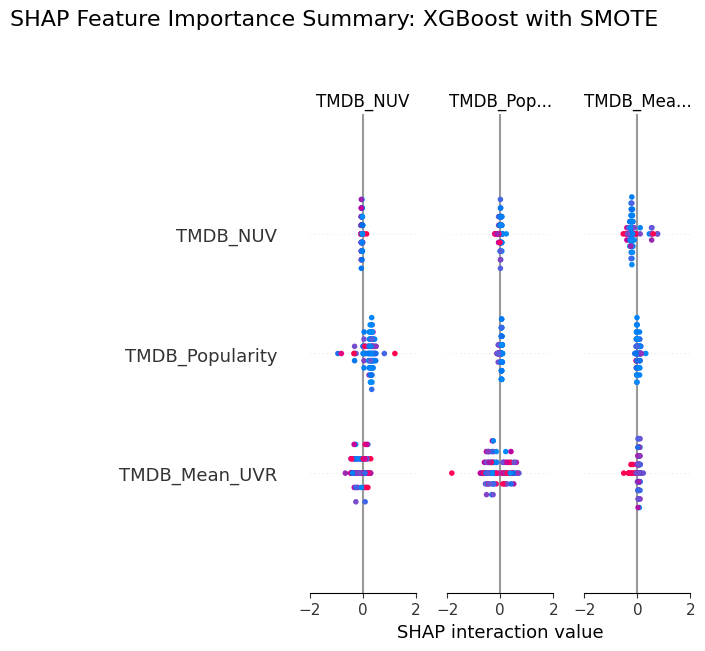

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Convert X_test to a pandas DataFrame with feature names
feature_names = X_encoded.columns  # Assuming you have this from earlier preprocessing
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Check for object columns
object_columns = X_test_df.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

# Convert object columns to numerical where applicable
for col in object_columns:
    # Attempt to convert to numeric
    try:
        X_test_df[col] = pd.to_numeric(X_test_df[col], errors='coerce')
    except Exception as e:
        print(f"Could not convert {col} to numeric: {e}")

# For categorical columns, use one-hot encoding or map to numerical values
# Example: X_test_df['categorical_column'] = X_test_df['categorical_column'].astype('category').cat.codes

# Drop or handle remaining NaN values after conversion
X_test_df = X_test_df.fillna(0)  # Replace NaN values with 0 or other appropriate values

# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_xgb_smote)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_df)

# Generate SHAP summary plot
plt.figure(figsize=(10, 8))  # Adjust figure size
shap.summary_plot(shap_values, X_test_df, show=False)  # Set show=False to customize the plot


# Access all subplots and adjust x-axis limits
axes = plt.gcf().axes  # Get all axes from the current figure
for ax in axes:
    ax.set_xlim(-2, 2)  # Set x-axis range for each subplot

# Customize Y-axis labels
plt.gca().tick_params(axis='y', labelsize=8)  # Reduce the font size of Y-axis labels

# Add a title for the entire figure
plt.suptitle("SHAP Feature Importance Summary: XGBoost with SMOTE", fontsize=16, x = 0.2)

# Adjust layout to avoid overlapping elements
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to make room for the title

# Save or show the plot
plt.savefig("shap_summary_customized_xgb_smote.png")
plt.show()

<Figure size 1000x800 with 0 Axes>

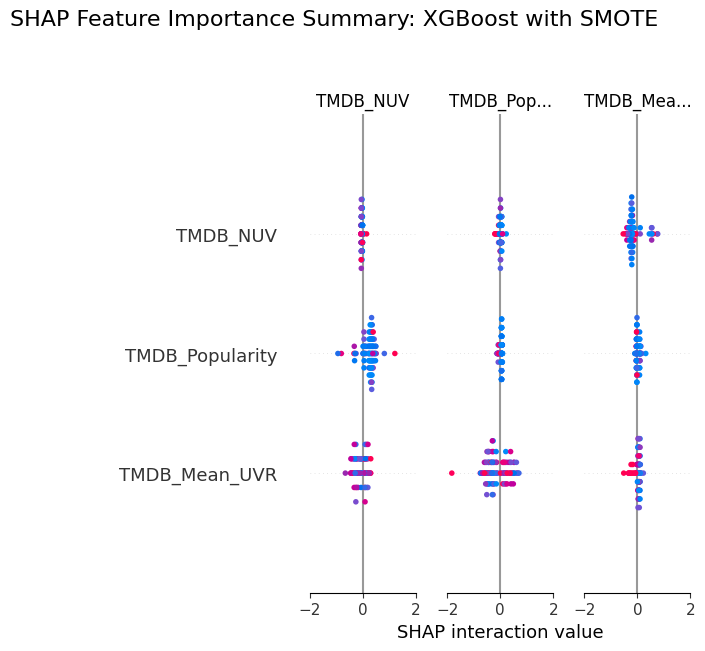

Saved SHAP summary plot for XGBoost with SMOTE as shap_summary_xgb_smote.png.


<Figure size 1000x800 with 0 Axes>

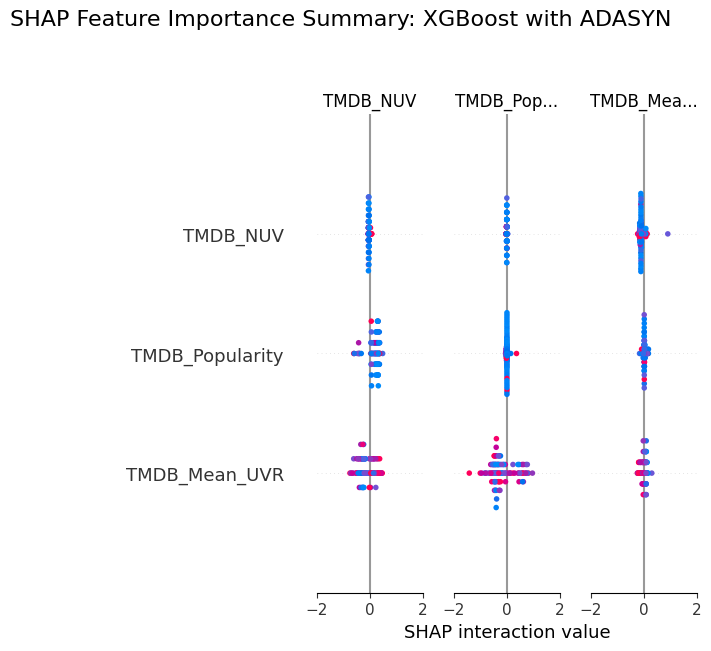

Saved SHAP summary plot for XGBoost with ADASYN as shap_summary_xgb_adasyn.png.


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

In [ ]:
# List of models and corresponding titles
models = [
    {"model": best_xgb_smote, "title": "XGBoost with SMOTE", "filename": "shap_summary_xgb_smote.png"},
    {"model": best_xgb_adasyn, "title": "XGBoost with ADASYN", "filename": "shap_summary_xgb_adasyn.png"},
    {"model": best_ada_smote, "title": "AdaBoost with SMOTE", "filename": "shap_summary_ada_smote.png"},
    {"model": best_ada_adasyn, "title": "AdaBoost with ADASYN", "filename": "shap_summary_ada_adasyn.png"},
    {"model": best_ann_smote, "title": "ANN with SMOTE", "filename": "shap_summary_ann_smote.png"},
    {"model": best_ann_adasyn, "title": "ANN with ADASYN", "filename": "shap_summary_ann_adasyn.png"}
]

# Loop through each model to create SHAP summary plots
for entry in models:
    model = entry["model"]
    title = entry["title"]
    filename = entry["filename"]

    # Check if the model is supported by TreeExplainer
    if "xgb" in title.lower() or "ada" in title.lower():  # TreeExplainer supported for XGBoost and AdaBoost
        explainer = shap.TreeExplainer(model)
    else:
        print(f"Skipping {title}: SHAP TreeExplainer does not support this model.")
        continue  # Skip unsupported models like ANN

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_df)

    # Generate SHAP summary plot
    plt.figure(figsize=(10, 8))  # Adjust figure size
    shap.summary_plot(shap_values, X_test_df, show=False)  # Set show=False to customize the plot

    # Access all subplots and adjust x-axis limits
    axes = plt.gcf().axes  # Get all axes from the current figure
    for ax in axes:
        ax.set_xlim(-2, 2)  # Set x-axis range for each subplot

    # Customize Y-axis labels
    plt.gca().tick_params(axis='y', labelsize=8)  # Reduce the font size of Y-axis labels

    # Add a title for the entire figure
    plt.suptitle(f"SHAP Feature Importance Summary: {title}", fontsize=16, x = 0.2)

    # Adjust layout to avoid overlapping elements
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to make room for the title

    # Save or show the plot
    plt.savefig(filename)
    plt.show()
    print(f"Saved SHAP summary plot for {title} as {filename}.")

<Figure size 1000x800 with 0 Axes>

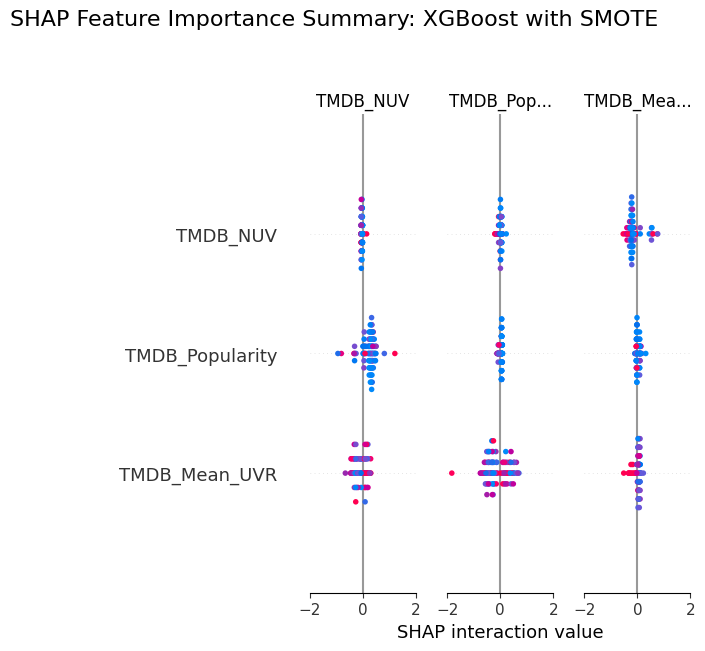

Saved SHAP summary plot for XGBoost with SMOTE as shap_summary_xgb_smote.png.


<Figure size 1000x800 with 0 Axes>

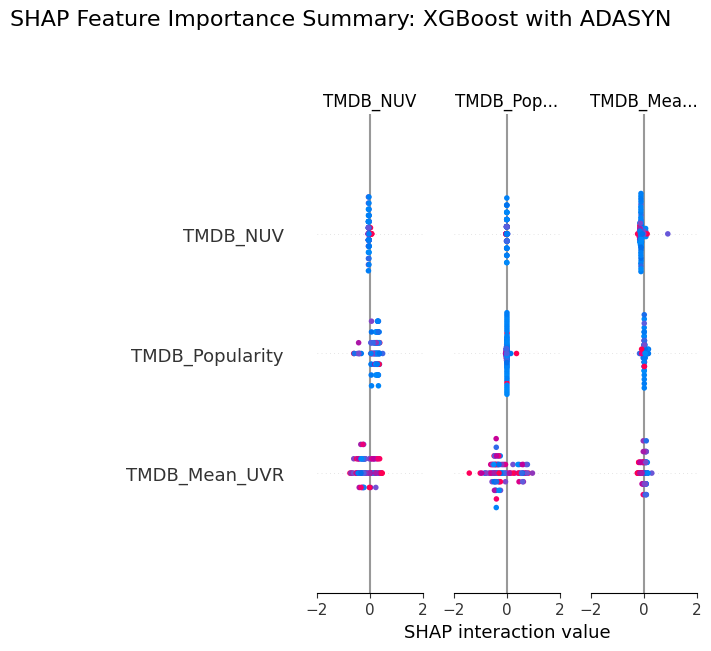

Saved SHAP summary plot for XGBoost with ADASYN as shap_summary_xgb_adasyn.png.
Skipping AdaBoost with SMOTE: SHAP TreeExplainer does not support this model.
Skipping AdaBoost with ADASYN: SHAP TreeExplainer does not support this model.
Skipping ANN with SMOTE: SHAP TreeExplainer does not support this model.
Skipping ANN with ADASYN: SHAP TreeExplainer does not support this model.


In [ ]:
# List of models and corresponding titles
models = [
    {"model": best_xgb_smote, "title": "XGBoost with SMOTE", "filename": "shap_summary_xgb_smote.png"},
    {"model": best_xgb_adasyn, "title": "XGBoost with ADASYN", "filename": "shap_summary_xgb_adasyn.png"},
    {"model": best_ada_smote, "title": "AdaBoost with SMOTE", "filename": "shap_summary_ada_smote.png"},
    {"model": best_ada_adasyn, "title": "AdaBoost with ADASYN", "filename": "shap_summary_ada_adasyn.png"},
    {"model": best_ann_smote, "title": "ANN with SMOTE", "filename": "shap_summary_ann_smote.png"},
    {"model": best_ann_adasyn, "title": "ANN with ADASYN", "filename": "shap_summary_ann_adasyn.png"}
]

# Loop through each model to create SHAP summary plots
for entry in models:
    model = entry["model"]
    title = entry["title"]
    filename = entry["filename"]

    # Check if the model is supported by TreeExplainer
    if "xgb" in title.lower():  # Only support XGBoost for SHAP
        explainer = shap.TreeExplainer(model)
    else:
        print(f"Skipping {title}: SHAP TreeExplainer does not support this model.")
        continue  # Skip unsupported models

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_df)

    # Generate SHAP summary plot
    plt.figure(figsize=(10, 8))  # Adjust figure size
    shap.summary_plot(shap_values, X_test_df, show=False)  # Set show=False to customize the plot

    # Access all subplots and adjust x-axis limits
    axes = plt.gcf().axes  # Get all axes from the current figure
    for ax in axes:
        ax.set_xlim(-2, 2)  # Set x-axis range for each subplot

    # Customize Y-axis labels
    plt.gca().tick_params(axis='y', labelsize=8)  # Reduce the font size of Y-axis labels

    # Add a title for the entire figure
    plt.suptitle(f"SHAP Feature Importance Summary: {title}", fontsize=16, x = 0.2)

    # Adjust layout to avoid overlapping elements
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to make room for the title

    # Save or show the plot
    plt.savefig(filename)
    plt.show()
    print(f"Saved SHAP summary plot for {title} as {filename}.")

In [ ]:
print("SHAP interaction features:", shap_interaction_values_class_1.shape[1])
print("Dataset features:", X_test_df.shape[1])

SHAP interaction features: 2142
Dataset features: 2142


In [ ]:
print("SHAP Interaction Values Shape:", shap_interaction_values.shape)
shap_interaction_values_class_1 = shap_interaction_values[..., 1]  # Extract class 1 values
print("Class 1 Interaction Values Shape:", shap_interaction_values_class_1.shape)

SHAP Interaction Values Shape: (100, 2142, 2142, 3)
Class 1 Interaction Values Shape: (100, 2142, 2142)


In [ ]:
print("X_test_df Shape:", X_test_df.shape)

X_test_df Shape: (100, 2142)


In [ ]:
interaction_values_for_primary = shap_interaction_values_class_1[:, primary_feature_idx, :]
print("Sliced SHAP Interaction Values Shape:", interaction_values_for_primary.shape)

Sliced SHAP Interaction Values Shape: (100, 2142)


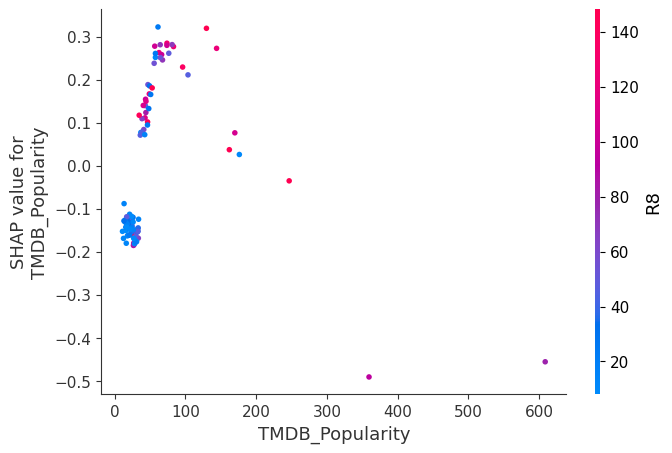

In [ ]:
shap.dependence_plot(
    primary_feature_idx,  # Index of the primary feature
    interaction_values_for_primary,  # Sliced interaction values
    X_test_df,  # Ensure this matches the SHAP interaction values
    show=True
)

<Figure size 1200x800 with 0 Axes>

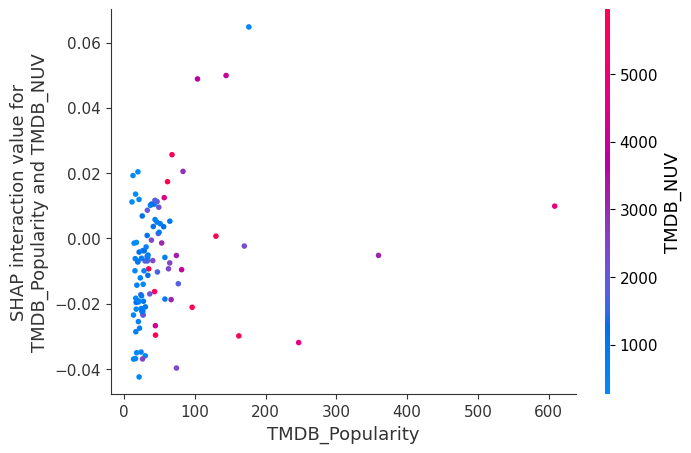

<Figure size 640x480 with 0 Axes>

In [ ]:
# Step 1: Select primary and interaction features
primary_feature = "TMDB_Popularity"  # Primary feature on the x-axis
interaction_feature = "TMDB_NUV"  # Feature for interaction

# Step 2: Get their indices
primary_feature_idx = X_test_df.columns.get_loc(primary_feature)
interaction_feature_idx = X_test_df.columns.get_loc(interaction_feature)

# Step 3: Plot interaction
plt.figure(figsize=(12, 8))
shap.dependence_plot(
    (primary_feature_idx, interaction_feature_idx),  # Primary and interaction features
    shap_interaction_values_class_1,  # Interaction values for class 1
    X_test_df,  # Dataset
    show=True,
)
# Ensure at least one axis exists
if len(plt.gcf().axes) > 0:
    ax1 = plt.gcf().axes[0]  # Access the first subplot
    ax1.set_title(f"SHAP Interaction Plot: {primary_feature} vs. {interaction_feature}", fontsize=16, pad=20)  # Add title

# Show the updated plot
plt.tight_layout()  # Avoid overlap
plt.show()

Generating SHAP Interaction Plot for XGBoost with SMOTE...


<Figure size 1200x800 with 0 Axes>

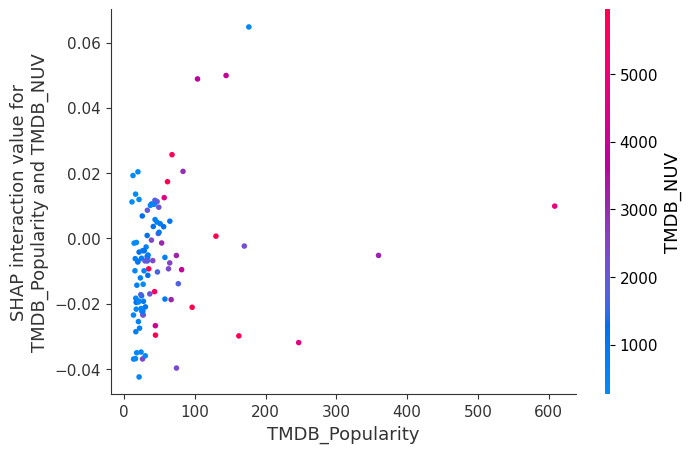

<Figure size 640x480 with 0 Axes>

Generating SHAP Interaction Plot for XGBoost with ADASYN...


<Figure size 1200x800 with 0 Axes>

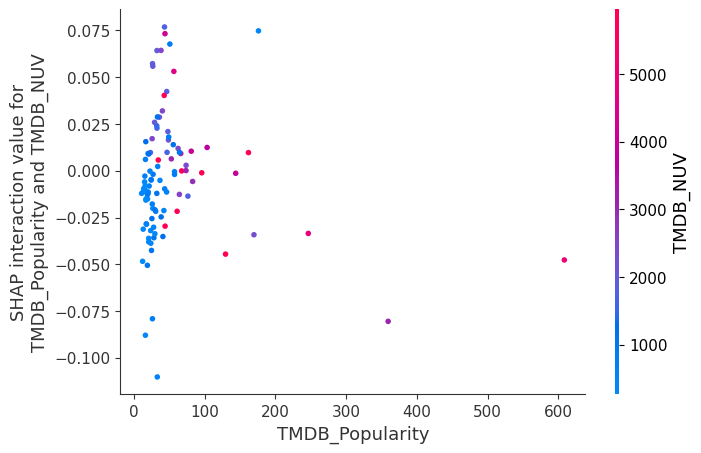

<Figure size 640x480 with 0 Axes>

In [ ]:
# List of models and their titles
models = [
    (best_xgb_smote, "XGBoost with SMOTE"),
    (best_xgb_adasyn, "XGBoost with ADASYN"),
    # Uncomment below lines if TreeExplainer supports the respective models in the future
    # (best_ada_smote, "AdaBoost with SMOTE"),
    # (best_ada_adasyn, "AdaBoost with ADASYN"),
    # (best_ann_smote, "ANN with SMOTE"),
    # (best_ann_adasyn, "ANN with ADASYN")
]

# Specify the primary and interaction features
primary_feature = "TMDB_Popularity"  # Feature on the x-axis
interaction_feature = "TMDB_NUV"  # Feature for interaction

# Get indices for the selected features
primary_feature_idx = X_test_df.columns.get_loc(primary_feature)
interaction_feature_idx = X_test_df.columns.get_loc(interaction_feature)

# Iterate through models
for model, title in models:
    print(f"Generating SHAP Interaction Plot for {title}...")

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)

    # Get SHAP interaction values for class 1 (adjust class as needed)
    shap_interaction_values = explainer.shap_interaction_values(X_test_df)
    shap_interaction_values_class_1 = shap_interaction_values[..., 1]  # Interaction values for class 1

    # Plot the interaction
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(
        (primary_feature_idx, interaction_feature_idx),  # Specify primary and interaction features
        shap_interaction_values_class_1,  # Use interaction values for class 1
        X_test_df,  # Dataset
        show=True,
    )

    # Ensure at least one axis exists
    if len(plt.gcf().axes) > 0:
        ax1 = plt.gcf().axes[0]  # Access the first subplot
        ax1.set_title(
            f"SHAP Interaction Plot: {primary_feature} vs. {interaction_feature}\n({title})",
            fontsize=16,
            pad=20
        )  # Add title

    # Adjust layout
    plt.tight_layout()

    # Save or show the plot
    plt.savefig(f"shap_interaction_{title.replace(' ', '_').lower()}.png")
    plt.show()

Processing XGBoost with SMOTE...
SHAP Interaction Values Shape: (100, 2142, 2142, 3)
Generating SHAP Interaction Plot for Class 0...


<Figure size 1200x800 with 0 Axes>

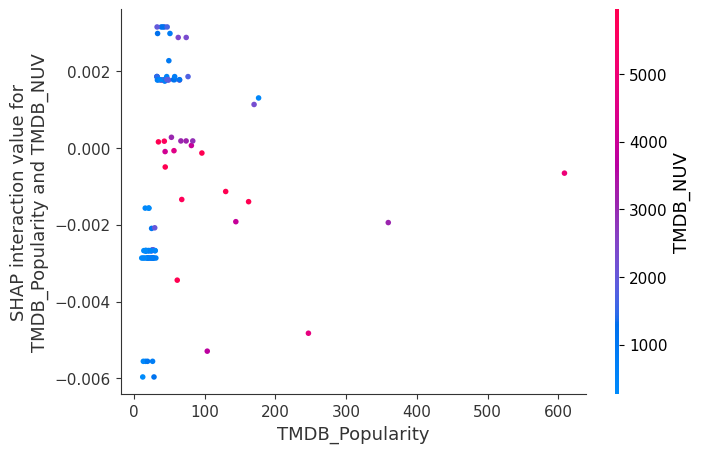

Saved plot as shap_interaction_xgboost_with_smote_class_0.png


<Figure size 640x480 with 0 Axes>

Generating SHAP Interaction Plot for Class 1...


<Figure size 1200x800 with 0 Axes>

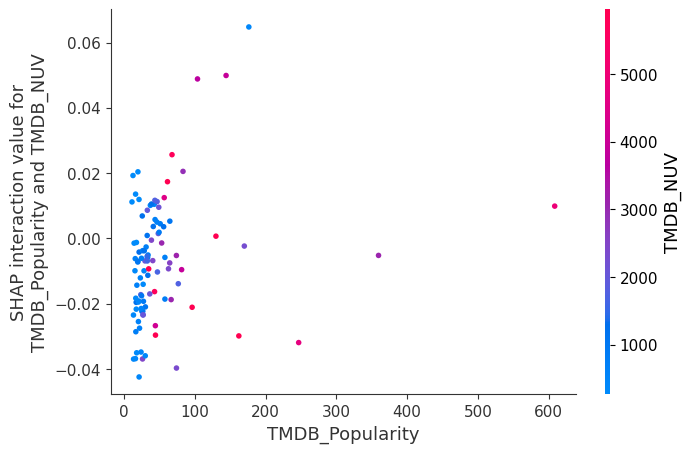

Saved plot as shap_interaction_xgboost_with_smote_class_1.png


<Figure size 640x480 with 0 Axes>

Generating SHAP Interaction Plot for Class 2...


<Figure size 1200x800 with 0 Axes>

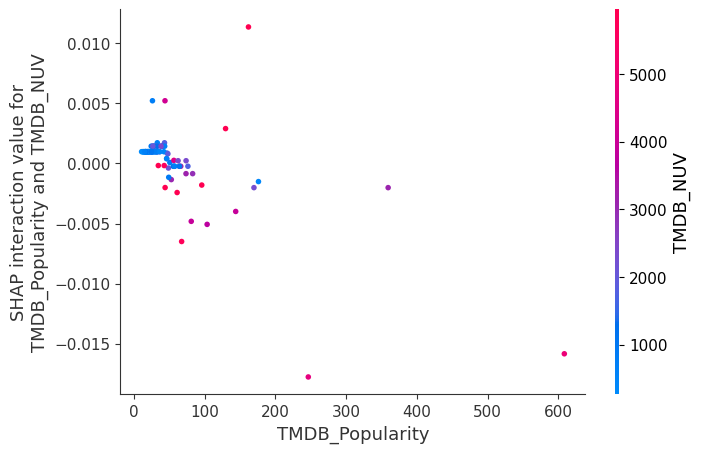

Saved plot as shap_interaction_xgboost_with_smote_class_2.png


<Figure size 640x480 with 0 Axes>

Processing XGBoost with ADASYN...
SHAP Interaction Values Shape: (100, 2142, 2142, 3)
Generating SHAP Interaction Plot for Class 0...


<Figure size 1200x800 with 0 Axes>

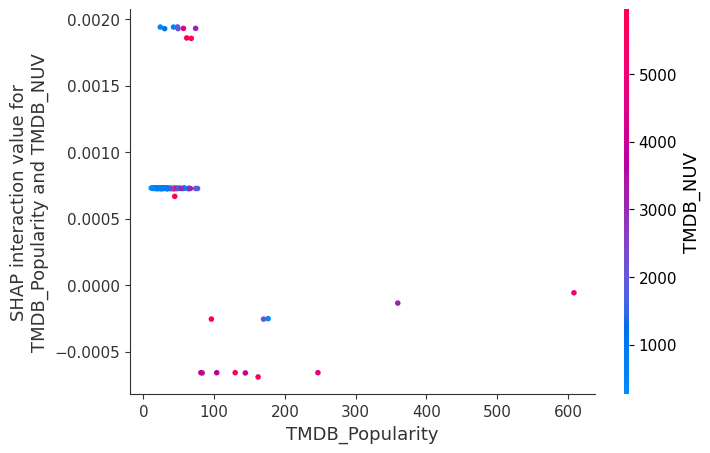

Saved plot as shap_interaction_xgboost_with_adasyn_class_0.png


<Figure size 640x480 with 0 Axes>

Generating SHAP Interaction Plot for Class 1...


<Figure size 1200x800 with 0 Axes>

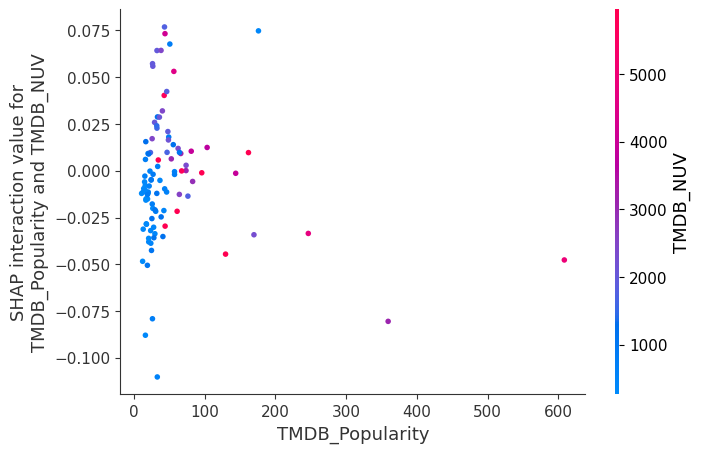

Saved plot as shap_interaction_xgboost_with_adasyn_class_1.png


<Figure size 640x480 with 0 Axes>

Generating SHAP Interaction Plot for Class 2...


<Figure size 1200x800 with 0 Axes>

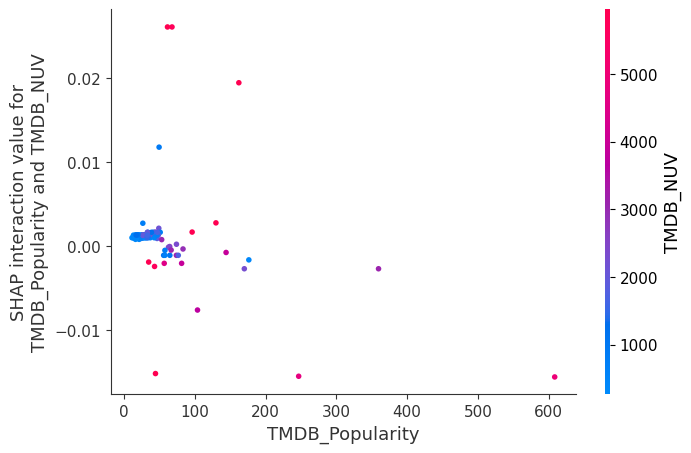

Saved plot as shap_interaction_xgboost_with_adasyn_class_2.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Step 1: Define the models and their SHAP Explainers ---
models_and_names = [
    ("XGBoost with SMOTE", best_xgb_smote),
    ("XGBoost with ADASYN", best_xgb_adasyn),
]

# Define your primary and interaction features
primary_feature = "TMDB_Popularity"  # Primary feature on the x-axis
interaction_feature = "TMDB_NUV"  # Feature for interaction

# Get indices for the selected features
primary_feature_idx = X_test_df.columns.get_loc(primary_feature)
interaction_feature_idx = X_test_df.columns.get_loc(interaction_feature)

# Iterate through models
for model_name, model in models_and_names:
    print(f"Processing {model_name}...")

    # Create SHAP explainer and interaction values
    explainer = shap.TreeExplainer(model)
    shap_interaction_values = explainer.shap_interaction_values(X_test_df)
    print(f"SHAP Interaction Values Shape: {shap_interaction_values.shape}")

    # Get the number of classes
    num_classes = shap_interaction_values.shape[-1]

    # Generate plots for each class
    for class_index in range(num_classes):
        print(f"Generating SHAP Interaction Plot for Class {class_index}...")

        # Get interaction values for the current class
        shap_interaction_values_class = shap_interaction_values[..., class_index]

        # Plot interaction
        plt.figure(figsize=(12, 8))
        shap.dependence_plot(
            (primary_feature_idx, interaction_feature_idx),  # Primary and interaction features
            shap_interaction_values_class,  # Interaction values for the current class
            X_test_df,  # Dataset
            show=True,
        )

        # Add a title for the plot
        if len(plt.gcf().axes) > 0:
            ax1 = plt.gcf().axes[0]  # Access the first subplot
            ax1.set_title(
                f"SHAP Interaction Plot: {primary_feature} vs. {interaction_feature}\n({model_name} - Class {class_index})",
                fontsize=16,
                pad=20
            )

        # Adjust layout
        plt.tight_layout()

        # Save the plot
        filename = f"shap_interaction_{model_name.replace(' ', '_').lower()}_class_{class_index}.png"
        plt.savefig(filename)
        print(f"Saved plot as {filename}")

        # Show the plot
        plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

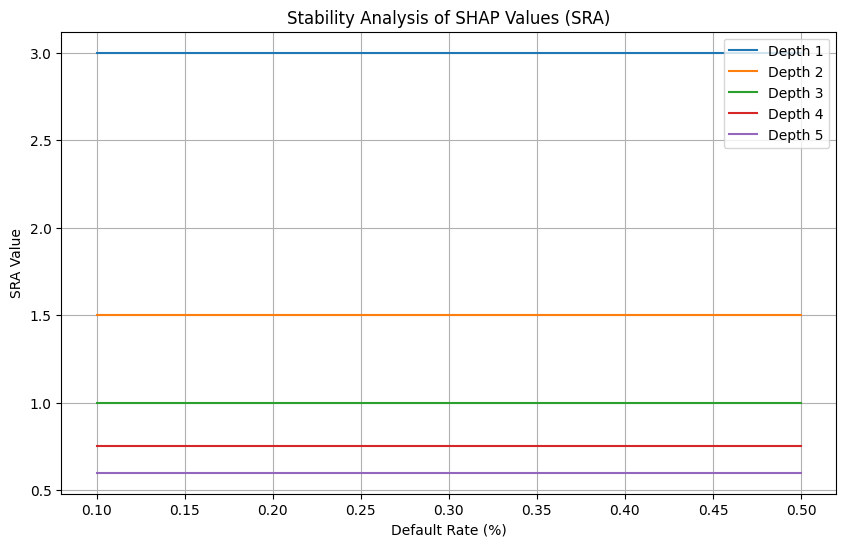

In [ ]:
import numpy as np
from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt

def calculate_sra(shap_values, depths):
    """
    Calculate SRA (Stability Ranking Agreement) values at specified depths.
    """
    sra_scores = []
    for depth in depths:
        # Use mean absolute SHAP values to rank features
        shap_ranking = np.argsort(-np.abs(shap_values).mean(axis=0))[:depth]
        sra_scores.append(len(np.unique(shap_ranking)) / depth)  # Stability measurement
    return sra_scores

def simulate_imbalance_and_calculate_sra(X_train, y_train, model, target_class, depths, imbalance_levels):
    """
    Simulate class imbalance and calculate SRA values.
    """
    sra_results = []

    for level in imbalance_levels:
        # Separate target and non-target classes
        target_indices = y_train == target_class
        non_target_indices = ~target_indices

        X_target = X_train[target_indices]
        y_target = y_train[target_indices]

        X_non_target = X_train[non_target_indices]
        y_non_target = y_train[non_target_indices]

        # Determine the number of samples for the target class
        max_samples = int(len(y_train) * level)
        max_samples = min(max_samples, len(X_target))  # Ensure we don't exceed available samples

        # Resample the target class to simulate imbalance
        X_target_resampled, y_target_resampled = resample(
            X_target,
            y_target,
            replace=False,
            n_samples=max_samples,  # Resample size based on the imbalance level
            stratify=y_target
        )

        # Combine the resampled target class with the non-target classes
        X_resampled = np.vstack([X_target_resampled, X_non_target])
        y_resampled = np.concatenate([y_target_resampled, y_non_target])

        # Train the model on the resampled data
        model.fit(X_resampled, y_resampled)

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_resampled)

        # Calculate SRA for the given depths
        sra_scores = calculate_sra(shap_values, depths)
        sra_results.append(sra_scores)

    return sra_results


# --- Define Parameters ---
depths = [1, 2, 3, 4, 5]  # Top features to consider for SRA calculation
imbalance_levels = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different levels of target class imbalance
target_class = 1  # Class for which imbalance is simulated

# Step 1: Simulate imbalance and calculate SRA for XGBoost with SMOTE
sra_values_smote = simulate_imbalance_and_calculate_sra(
    X_train_smote, y_train_smote, best_xgb_smote, target_class, depths, imbalance_levels
)

# Step 2: Plot the SRA Values
plt.figure(figsize=(10, 6))
for i, depth in enumerate(depths):
    plt.plot(
        imbalance_levels,
        [sra[depth - 1] for sra in sra_values_smote],
        label=f"Depth {depth}"
    )

plt.title("Stability Analysis of SHAP Values (SRA)")
plt.xlabel("Default Rate (%)")
plt.ylabel("SRA Value")
plt.legend()
plt.grid()
plt.show()


In [ ]:
def simulate_imbalanced_data(X, y, default_rate):
    """
    Simulate imbalanced data by under-sampling the majority class.

    Parameters:
        X (np.ndarray or pd.DataFrame): Feature dataset.
        y (np.ndarray or pd.Series): Target dataset.
        default_rate (float): Fraction of the majority class to retain.

    Returns:
        X_resampled (np.ndarray or pd.DataFrame): Resampled feature dataset.
        y_resampled (np.ndarray or pd.Series): Resampled target dataset.
    """
    # Find the majority class
    majority_class = np.argmax(np.bincount(y))
    majority_indices = np.where(y == majority_class)[0]
    minority_indices = np.where(y != majority_class)[0]

    # Retain a fraction of the majority class
    n_retain = int(len(majority_indices) * default_rate)
    retained_majority_indices = np.random.choice(majority_indices, n_retain, replace=False)

    # Combine with minority indices
    combined_indices = np.concatenate([retained_majority_indices, minority_indices])
    np.random.shuffle(combined_indices)

    # Use appropriate indexing based on the type of X and y
    if isinstance(X, pd.DataFrame):
        X_resampled = X.iloc[combined_indices]
    else:
        X_resampled = X[combined_indices]

    if isinstance(y, pd.Series):
        y_resampled = y.iloc[combined_indices]
    else:
        y_resampled = y[combined_indices]

    return X_resampled, y_resampled


In [ ]:
print(f"Type of X: {type(X)}, Shape of X: {X.shape}")
print(f"Type of y: {type(y)}, Shape of y: {y.shape}")


Type of X: <class 'pandas.core.frame.DataFrame'>, Shape of X: (1558, 34)
Type of y: <class 'pandas.core.series.Series'>, Shape of y: (1558,)


In [ ]:
for rate in imbalance_levels:
    X_resampled, y_resampled = simulate_imbalanced_data(X_train, y_train, rate)
    print(f"Default rate: {rate}")
    print(f"Class distribution: {np.bincount(y_resampled)}")

Default rate: 0.1
Class distribution: [348 208  69]
Default rate: 0.2
Class distribution: [348 208 138]
Default rate: 0.3
Class distribution: [348 208 207]
Default rate: 0.4
Class distribution: [348 208 276]
Default rate: 0.5
Class distribution: [348 208 345]


Calculating SRA for XGBoost with SMOTE...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Calculating SRA for XGBoost with ADASYN...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:20:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

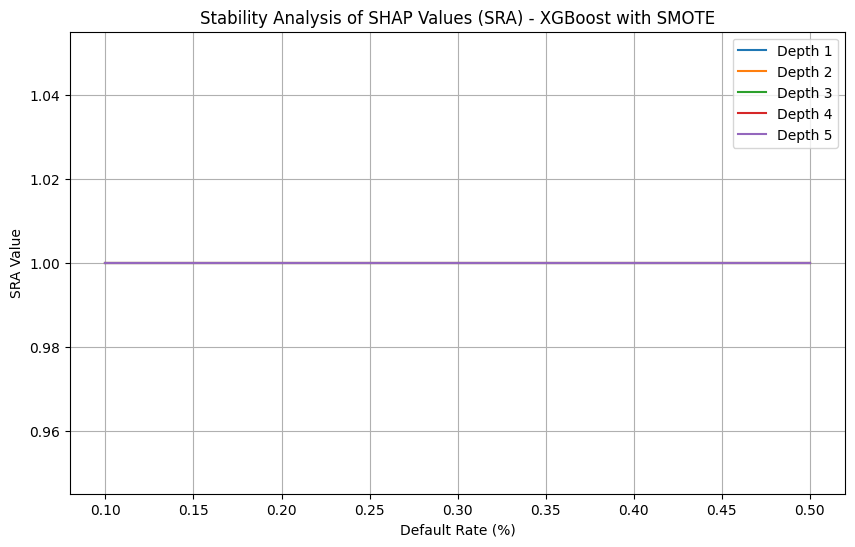

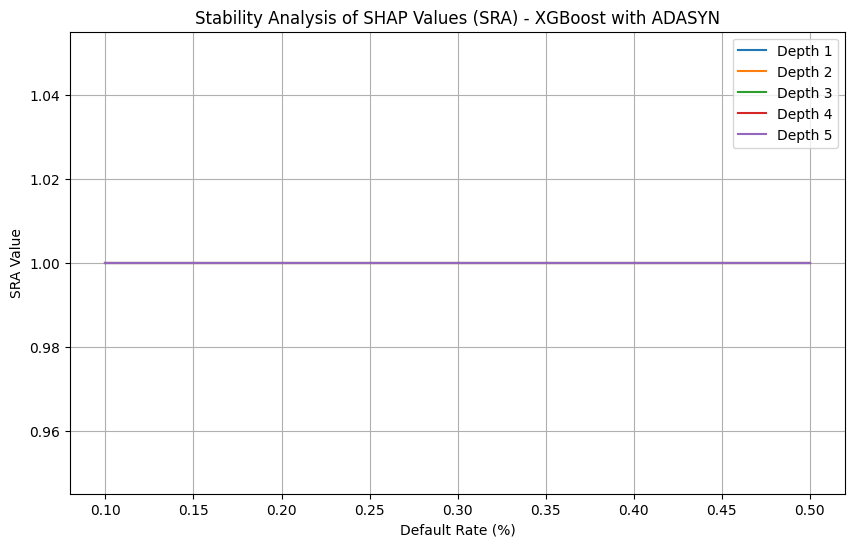

In [ ]:
import numpy as np

# Function to calculate Stability Rate Analysis (SRA)
def calculate_sra(shap_values, original_shap_values, depths):
    """
    Calculate the Stability Rate Analysis (SRA) values for SHAP.

    Parameters:
        shap_values (np.ndarray): SHAP values for the resampled dataset.
        original_shap_values (np.ndarray): Original SHAP values for the full dataset.
        depths (list): Depth levels for SRA calculation.

    Returns:
        sra_values (list): Calculated SRA values for each depth.
    """
    sra_values = []
    for depth in depths:
        # Select top `depth` features from the original SHAP values
        top_features_idx = np.argsort(np.abs(original_shap_values).mean(axis=0))[-depth:]
        # Compute SRA for the selected features
        stability = np.mean(np.isin(
            np.argsort(np.abs(shap_values).mean(axis=0))[-depth:], top_features_idx
        ))
        sra_values.append(stability)
    return sra_values

# Function to simulate imbalance and calculate SRA
def simulate_imbalance_and_calculate_sra(X, y, model, original_shap_values, depths, imbalance_levels):
    """
    Simulate imbalance and calculate SRA for given imbalance levels.

    Parameters:
        X (np.ndarray): Feature dataset.
        y (np.ndarray): Target dataset.
        model (XGBoost): Trained model.
        original_shap_values (np.ndarray): SHAP values for the full dataset.
        depths (list): Depth levels for SRA calculation.
        imbalance_levels (list): List of default rates to simulate imbalance.

    Returns:
        sra_results (list): SRA values for each imbalance level and depth.
    """
    sra_results = []
    for rate in imbalance_levels:
        # Simulate imbalance
        X_resampled, y_resampled = simulate_imbalanced_data(X, y, rate)
        # Fit model on resampled data
        model.fit(X_resampled, y_resampled)
        # Calculate SHAP values for resampled data
        explainer = shap.TreeExplainer(model)
        shap_values_resampled = explainer.shap_values(X_resampled)
        # Calculate SRA
        sra_values = calculate_sra(shap_values_resampled, original_shap_values, depths)
        sra_results.append(sra_values)
    return np.array(sra_results)

# Parameters
depths = [1, 2, 3, 4, 5]  # Depth levels for SRA
imbalance_levels = [0.1, 0.2, 0.3, 0.4, 0.5]  # Default rates

# Original SHAP values (calculate once for the full dataset)
explainer = shap.TreeExplainer(best_xgb_smote)  # Example model
original_shap_values = explainer.shap_values(X_train)

# Step 1: Simulate imbalance and calculate SRA for XGBoost with SMOTE
print("Calculating SRA for XGBoost with SMOTE...")
sra_values_smote = simulate_imbalance_and_calculate_sra(
    X_train_smote, y_train_smote, best_xgb_smote, original_shap_values, depths, imbalance_levels
)

# Step 2: Simulate imbalance and calculate SRA for XGBoost with ADASYN
print("Calculating SRA for XGBoost with ADASYN...")
sra_values_adasyn = simulate_imbalance_and_calculate_sra(
    X_train_adasyn, y_train_adasyn, best_xgb_adasyn, original_shap_values, depths, imbalance_levels
)

# Step 3: Plot the SRA results
import matplotlib.pyplot as plt

def plot_sra(sra_values, depths, imbalance_levels, title):
    """
    Plot Stability Rate Analysis (SRA) results.

    Parameters:
        sra_values (np.ndarray): SRA values for each depth and imbalance level.
        depths (list): Depth levels for SRA.
        imbalance_levels (list): Default rates for imbalance.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    for i, depth in enumerate(depths):
        plt.plot(imbalance_levels, sra_values[:, i], label=f"Depth {depth}")
    plt.title(title)
    plt.xlabel("Default Rate (%)")
    plt.ylabel("SRA Value")
    plt.legend()
    plt.grid()
    plt.show()

# Plot results for both models
plot_sra(sra_values_smote, depths, imbalance_levels, "Stability Analysis of SHAP Values (SRA) - XGBoost with SMOTE")
plot_sra(sra_values_adasyn, depths, imbalance_levels, "Stability Analysis of SHAP Values (SRA) - XGBoost with ADASYN")
